In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
from sympy import latex
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os,sys,math
from sympy import *
import time
from zipfile import ZipFile
from matplotlib import rc
rc('mathtext', fontset='cm')
import matplotlib.colors as mcolors


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
#%matplotlib inline
#%matplotlib notebook

#### Scikit Learn

In [3]:
# Pipeline-Linear Regression model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
# Grid search technique
from sklearn.model_selection import GridSearchCV
#cross validation
from sklearn.model_selection import cross_validate, LeaveOneOut

#### Data 

In [4]:
df_static = pd.read_csv('./NS_data_for_each_EoS/static_data')
df = pd.read_csv('./NS_data_for_each_EoS/tot_data')

In [5]:
df.columns

Index(['Rpole_num', 'Req_num', 'Rpol/Req', 'ellipticity', 'eccentricity',
       'P_c', 'rho_c', 'r_ratio', 'r_e', 'M', 'M(km)', 'Req', 'C', 'K',
       'g_0(km^(-1))', 'I(kgkm^2)', 'I(km^3)', 'Ibar', 'Z_p', 'Z_b', 'Z_f',
       'Ω(Hz)', 'f(Hz)', 'f_tilde', 'Jgeom(km^2)', 'x', 'sigma', 'T/W',
       'Mxf_tilde', 'Rxf_tilde', 'conv_rad', 'conv_plus', 'conv_minus',
       'h_plus', 'h_minus', 'r_plus', 'r_minus', 'Q(km^3)', 'Qbar', 'S3(km^4)',
       'S3bar', 'M4_geom', 'M4_asy^GH_geom', 'M4_asy_geom', 'M4_geom_2points',
       'M4_geom_3points', 'M4_geom_4points', 'S5_geom', 'S5_asy_geom', 'EoS',
       'g_scaled', 'g_eq_scaled', 'g_pole_scaled', 'dR_dtheta_max'],
      dtype='object')

In [6]:
selected_features = ['r_ratio','C','sigma','f(Hz)','Rpole_num','Req_num','Rpol/Req','eccentricity','g_0(km^(-1))','g_scaled', 'g_eq_scaled', 'g_pole_scaled', 'dR_dtheta_max','EoS']

In [7]:
df_static[selected_features].to_csv('static_data_2',index=False)

In [21]:
#pd.read_csv('static_data_2')

In [22]:
#df[selected_features].to_csv('tot_data_2',index=False)

In [24]:
#pd.read_csv('tot_data_2')

In [8]:
#df[selected_features][df['r_ratio']>=0.6].to_csv('tot_data_2',index=False)


In [7]:
#df = df[df['r_ratio']>=0.6].copy()
df2 = df[(df['r_ratio']>=0.6) &(df['sigma']!= 0)].copy()  #Static NSs are excluded

In [8]:
#df.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

In [7]:
df['g_eq/g_pole'] = df['g_eq_scaled']/df['g_pole_scaled']
df['g_pole/g_eq'] = df['g_eq/g_pole']**(-1)


In [8]:
eos_labels = [np.unique(df['EoS'])[i] for i in range(0, len(np.unique(df['EoS'])))]

# Choose the values relevant for each EoS
unique_values = np.unique(df['EoS']) # EoS labels

# Separate the DataFrame into a list of DataFrames based on unique 'EoS' values
eos_data = [df[df['EoS'] == value].reset_index(drop=True) for value in unique_values]
eos_data2 = [df2[df2['EoS'] == value].reset_index(drop=True) for value in unique_values]


C_s,sigma_s, e_s, r_s = symbols("\mathcal{C}, \sigma, e, r_{\star}")

Q_s, lnQ_s, M_s, f_s = symbols("\bar{Q}, \ln(\bar{Q}), M, \tilde{f}")


In [10]:
all_data = df[['C','sigma','eccentricity','Rpol/Req', 'g_eq_scaled', 'g_pole_scaled' ]]

In [49]:
c_color = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow',
          'brown', 'pink', 'olive', 'gray', 'lime', 'teal', 'gold', 'indigo', 'violet',
          'salmon', 'orchid', 'seagreen', 'sienna', 'darkorange', 'lightcoral', 'dodgerblue',
          'darkslategray', 'crimson', 'limegreen', 'maroon', 'peru', 'royalblue', 'slateblue',
          'mediumseagreen', 'turquoise', 'deeppink', 'darkviolet', 'darkseagreen', 'navy',
          'chocolate', 'mediumblue', 'slategray', 'cadetblue', 'forestgreen', 'orangered',
          'gold', 'cornflowerblue', 'darkcyan', 'darkolivegreen', 'rosybrown',
          'sienna', 'darkred', 'tomato', 'dimgrey', 'darkgreen', 'hotpink', 'burlywood',
          'midnightblue', 'darkblue', 'darkslateblue', 'firebrick', 'darkturquoise', 'plum',
          'greenyellow', 'black', 'lightgray', 'darkgray', 'deepskyblue',
          'lavender', 'palevioletred', 'darkmagenta', 'slategrey', 'turquoise', 'limegreen',
          'lightcoral']

#### Cross validation pipeline for polynomial model features

In [13]:
def cross_validation_function(data_frame, x,y,z, pol_degree):
    # Formula to predict and testing the unkown data with leaveout function
    
    #Data, targets
    train_data = data_frame[[x, y]].to_numpy()
    target = data_frame[z].to_numpy()
    
    #------Pipeline------------------------
    model = Pipeline([("poly", PolynomialFeatures(degree=pol_degree)),("linear_reg", LinearRegression())])
    
    # Scores: statistical evaluation score functions from scikit learn
    scores = ["max_error","neg_mean_absolute_error","neg_mean_squared_error","neg_root_mean_squared_error",
              "explained_variance","neg_mean_absolute_percentage_error"]
    cv_results = cross_validate(model, train_data, target, cv = LeaveOneOut(), scoring=scores, n_jobs = 3) #5-fold CV #LeaveOneOut()
    
    #------Results at cross-validation saved in Data Fame-----------
    cv_results = pd.DataFrame(cv_results)
    
    #----Statistical evaluation metric functions----------------
    #---------------calculation---------------------------------
    mean_MAE = (-cv_results['test_neg_mean_absolute_error']).mean()
    mean_MSE = (-cv_results['test_neg_mean_squared_error']).mean()
    max_validation_error = (-cv_results['test_max_error']).max()
    max_relative_valitation_error = (-100*cv_results['test_neg_mean_absolute_percentage_error']).max()
    MAPE_validation_error = (-100*cv_results['test_neg_mean_absolute_percentage_error']).mean()
    explained_variance = (cv_results['test_explained_variance']).mean()
    useful_output_data = np.array([mean_MAE,max_validation_error,mean_MSE,max_relative_valitation_error,
                          MAPE_validation_error,explained_variance,pol_degree])
    
    #--------------data saved to data frame---------------------------
    useful_data_frame = pd.DataFrame(useful_output_data)
    names = ['MAE','Max_Error','MSE','d(%)','MAPE(%)','Explained_Variance','k']
    
    #--------------Final output----------------------------------------
    validation_evaluation_metrics = pd.DataFrame(useful_data_frame.values.reshape(1,7), columns = names)
  
    
    return cv_results, validation_evaluation_metrics, useful_output_data

In [14]:
def cross_validation_function_2(data_frame, x,y,w,z, pol_degree):
    # Formula to predict and testing the unkown data with leaveout function
    
    #Data, targets
    train_data = data_frame[[x, y, w]].to_numpy()
    target = data_frame[z].to_numpy()
    
    #------Pipeline------------------------
    model = Pipeline([("poly", PolynomialFeatures(degree=pol_degree)),("linear_reg", LinearRegression())])
    
    # Scores: statistical evaluation score functions from scikit learn
    scores = ["max_error","neg_mean_absolute_error","neg_mean_squared_error","neg_root_mean_squared_error",
              "explained_variance","neg_mean_absolute_percentage_error"]
    cv_results = cross_validate(model, train_data, target, cv = LeaveOneOut(), scoring=scores, n_jobs = 3) #5-fold CV #LeaveOneOut()
    
    #------Results at cross-validation saved in Data Fame-----------
    cv_results = pd.DataFrame(cv_results)
    
    #----Statistical evaluation metric functions----------------
    #---------------calculation---------------------------------
    mean_MAE = (-cv_results['test_neg_mean_absolute_error']).mean()
    mean_MSE = (-cv_results['test_neg_mean_squared_error']).mean()
    max_validation_error = (-cv_results['test_max_error']).max()
    max_relative_valitation_error = (-100*cv_results['test_neg_mean_absolute_percentage_error']).max()
    MAPE_validation_error = (-100*cv_results['test_neg_mean_absolute_percentage_error']).mean()
    explained_variance = (cv_results['test_explained_variance']).mean()
    useful_output_data = np.array([mean_MAE,max_validation_error,mean_MSE,max_relative_valitation_error,
                          MAPE_validation_error,explained_variance,pol_degree])
    
    #--------------data saved to data frame---------------------------
    useful_data_frame = pd.DataFrame(useful_output_data)
    names = ['MAE','Max_Error','MSE','d(%)','MAPE(%)','Explained_Variance','k']
    
    #--------------Final output----------------------------------------
    validation_evaluation_metrics = pd.DataFrame(useful_data_frame.values.reshape(1,7), columns = names)
  
    
    return cv_results, validation_evaluation_metrics, useful_output_data

In [15]:
def c_val_performace_results_for_k(df,x,y,z):
    stat_metric_list_at_cv = list()
    for i in range(1,9):
        print(f'Order of the polynomial function: {i}')
        performance_results_at_cv = cross_validation_function(df, x = x,y= y ,z=z, pol_degree=i)
        print(performance_results_at_cv[1])
        stat_metric_list_at_cv.append(performance_results_at_cv[2])   
    
    names = ['MAE','Max_Error','MSE','d(%)','MAPE(%)','Explained_Variance','k']    
    df = pd.DataFrame(stat_metric_list_at_cv, columns =names)
    return df

In [16]:
def c_val_performace_results_for_k_2(df,x,y,w,z):
    stat_metric_list_at_cv = list()
    for i in range(1,9):
        print(f'CV for pol degree k = {i}')
        print(f'Order of the polynomial function: {i}')
        performance_results_at_cv = cross_validation_function_2(df, x = x,y= y,w=w ,z=z, pol_degree=i)
        print(performance_results_at_cv[1])
        stat_metric_list_at_cv.append(performance_results_at_cv[2])   
    
    names = ['MAE','Max_Error','MSE','d(%)','MAPE(%)','Explained_Variance','k']    
    df = pd.DataFrame(stat_metric_list_at_cv, columns =names)
    return df

####  Linear Regression function

In [17]:
def Regression_function(data_frame,x,y,z,pol_degree, x_power,y_power):
    # Data, targets
    train_data = data_frame[[x, y]].to_numpy()
    target = data_frame[z].to_numpy()
    
    #--------Polynomial features and defining the model---------------
    poly = PolynomialFeatures(degree=pol_degree) 
    model=LinearRegression(fit_intercept=True) #Lasso Ridge(fit_intercept=True, alpha=0.000000010)
    #-----------Applying transformation to the data-------------------
    poly_train_data = poly.fit_transform(train_data)
    
    #-----------Trainig the regression model--------------------------
    model = model.fit(poly_train_data, target)
    
    #----------Scoring: R^2 index------------------------------------
    R_square_index = model.score(poly_train_data, target)
    
    #---------z=f(x,y) prediction with respect to the model----------
    z_trial = model.predict(poly_train_data)
    z_trial = pd.DataFrame(z_trial)
    
    #----------fitting optimizers (coefficients)---------------------
    intercept_coeff = model.intercept_
    model_coeff = model.coef_
    power_combinations = poly.powers_
    powers=pd.DataFrame(poly.powers_,columns=[x_power,y_power])
   
    return z_trial, R_square_index, intercept_coeff, model_coeff, power_combinations, powers


#### Relative errors

In [18]:
def relative_training_error_plot(data_frame, z , z_trial, xlabel, ylabel): 
    
    fig,ax = plt.subplots(figsize=(12, 6),)  
    labels_text_size = 20

    plt.xlabel(xlabel,size=labels_text_size)
    plt.ylabel(ylabel,size=labels_text_size)
    plt.xscale('linear')
    plt.yscale('linear')
    plt.xticks(fontsize=14, fontweight="bold")
    plt.yticks(fontsize=14, fontweight="bold")
    
    plot_representation = (100*(-data_frame[z]+data_frame[z_trial])/data_frame[z]).plot(marker='o', label = 'Relative Error'); #,figsize=(20,15)
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3.0)
    
    leg = plt.legend(loc='best',framealpha = 0.8,fontsize=14)
    leg.get_frame().set_linewidth(2.0)
    leg.get_frame().set_edgecolor('black')
    
    plt.grid(False)
    plt.tight_layout()
    #save_fig = plt.savefig(fig_title,dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()
        
    return plot_representation

In [19]:
def training_error_funct(data_frame, z , z_trial):
    
    # computation statistical metric functions at training data
    
    # mean relative training error
    train_mape_error = (100*abs((-data_frame[z]+data_frame[z_trial])/data_frame[z])).mean()
    
    # max training relative error calculation
    train_relat_max_errorr = np.max(100*abs(-data_frame[z]+data_frame[z_trial])/data_frame[z])
    
    # max training error calculation
    train_max_error = np.max(abs(-data_frame[z]+data_frame[z_trial]))
    
    #--------put results in an array---------------
    useful_output_data = np.array([train_max_error,train_relat_max_errorr,train_mape_error])
    
    #--------------Store data to dataframe-------------
    useful_data_frame = pd.DataFrame(useful_output_data)
    names = ['train_Max_Error','d_max_training(%)','MAPE_taining(%)']
    
    #--------------Final output------------------
    training_evaluation_metrics = pd.DataFrame(useful_data_frame.values.reshape(1,3), columns = names)
   
    return training_evaluation_metrics
    


In [20]:
def training_relative_error_hist(data_frame, z, z_trial, xlabel, ylabel,n_bins, x1_lim, x2_lim):

    fig,ax = plt.subplots(figsize=(12, 6),)
    labels_text_size = 20
    plt.xticks(fontsize=18, fontweight="bold")
    plt.yticks(fontsize=18, fontweight="bold")

    plt.xlabel(xlabel,size=labels_text_size)
    plt.ylabel(ylabel,size=labels_text_size)

    x = (100*(-data_frame[z]+data_frame[z_trial])/data_frame[z]).hist(bins=n_bins,edgecolor ='k').autoscale(enable = True, axis = 'both', tight = True)
    
    plt.xlim(x1_lim,x2_lim)
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4.0)

    plt.grid(False)
    plt.tight_layout()
    plt.savefig('hist.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.2)
    
    plt.show()


In [21]:
def relative_error_space_distribution(data_frame, x , y ,z, z_trial, xlabel,ylabel, zlabel, view2):
    fig = plt.figure(figsize=(10, 6)) 
    labels_text_size = 35
    
    ax = fig.add_subplot(111, projection='3d')
    
    dot_size = 40
    font_size = 30
    label_pad = 25
    label_size = 25
    
    ax.scatter3D(data_frame[x], data_frame[y], 100*abs(data_frame[z_trial]-data_frame[z])/data_frame[z], color='black', s=dot_size)    
    
    ax.view_init(30, view2)   
    ax.set_xlabel(xlabel, fontsize=font_size,labelpad=label_pad) 
    ax.set_ylabel(ylabel, fontsize=font_size,labelpad=label_pad) 
    ax.set_zlabel(zlabel, fontsize=font_size,labelpad=label_pad) 
    ax.yaxis._axinfo['label']['space_factor'] = 2.0 
    ax.xaxis._axinfo['label']['space_factor'] = 2.0 
    ax.zaxis._axinfo['label']['space_factor'] = 3.0 
    
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.zaxis.set_tick_params(labelsize=label_size)
    
    #for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
     #   axis.line.set_linewidth(4)
    

    ax.grid(False)
    plt.tight_layout()
    #plt.savefig('fig_title.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.2)

    plt.show()
    

In [22]:
def variance_of_errors(df,reference_deviation,z,z_model):
    
    df['rel_error'] = 100*abs((z_model - z)/z)
    df_new = df[df['rel_error']>=reference_deviation] 
    return df_new

####  Surface plot $Z=F(x,y)$

In [23]:
def Surface_plot_funct(eos_data, x,y,z, xlabel,ylabel,zlabel, view2, n_col, border_axes):
    
    fig = plt.figure(figsize=(10, 6)) 
    labels_text_size = 15
    ax = fig.add_subplot(111, projection='3d')

    dot_size = 40
    font_size = 25
    label_pad = 24
    label_size = 15

    for i in range(0, len(eos_data)):
        ax.scatter3D(eos_data[i][x].to_numpy(),eos_data[i][y].to_numpy(),eos_data[i][z].to_numpy(),
                     s=dot_size, c=c_color[i], label = eos_labels[i])    

  
    ax.view_init(30, view2)   
    ax.set_xlabel(xlabel, fontsize=font_size,labelpad=label_pad) 
    ax.set_ylabel(ylabel, fontsize=font_size,labelpad=label_pad) 
    ax.set_zlabel(zlabel, fontsize=font_size) 

    #ax.xaxis._axinfo['label']['space_factor'] = 3.0 
    #ax.yaxis._axinfo['label']['space_factor'] = 3.0   
    #ax.zaxis._axinfo['label']['space_factor'] = 3.0 
    
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.zaxis.set_tick_params(labelsize=label_size)
    
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.line.set_linewidth(3)
    
    ax.grid(False)


    #plt.legend(loc="best",ncol=n_col, borderaxespad=border_axes, prop={'size': 10}, shadow=True, fontsize="large",bbox_to_anchor=(1,1))    #,bbox_to_anchor=(1,1)
    plt.tight_layout()
    #plt.savefig('fig_title',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0)
    plt.show()
    

In [24]:
def mesh_grid_funct(number_of_points, data_frame,x_name, y_name):
    
    number_of_points = number_of_points
    
    x = np.linspace(data_frame[x_name].min(), data_frame[x_name].max(),number_of_points)
    y = np.linspace(data_frame[y_name].min(), data_frame[y_name].max(),number_of_points)
    
    X,Y = np.meshgrid(x, y)
    
    return X,Y

In [25]:
def mesh_grid_funct_2(number_of_points, data_frame,x_name, y_name, w_name):
    
    number_of_points = number_of_points
    
    x = np.linspace(data_frame[x_name].min(), data_frame[x_name].max(),number_of_points)
    y = np.linspace(data_frame[y_name].min(), data_frame[y_name].max(),number_of_points)
    w = np.linspace(data_frame[w_name].min(), data_frame[w_name].max(),number_of_points)
    X,Y,W = np.meshgrid(x, y, w)
    
    return X,Y,W

In [26]:
def Surface_plot_funct_2(eos_data, x,y,z, xlabel,ylabel,zlabel, view2, n_col, border_axes, X,Y,Z, l_w):
    
    fig = plt.figure(figsize=(12, 8)) 
    labels_text_size = 25
    ax = fig.add_subplot(111, projection='3d')

    dot_size = 40
    font_size = 30
    label_pad = 25
    label_size = 25

    for i in range(0, len(eos_data)):
        ax.scatter3D(eos_data[i][x].to_numpy(),eos_data[i][y].to_numpy(),eos_data[i][z].to_numpy(),
                     s=dot_size, c=c_color[i], label = eos_labels[i])    

    
    ax.plot_wireframe(X, Y, Z, rstride=40, cstride=40,edgecolor='blue' ,color = 'black',
                      alpha=0.6, lw = l_w, antialiased=True)

    
    
    ax.view_init(30, view2)   
    #ax.set_xlabel(xlabel, fontsize=font_size,labelpad=label_pad) 
    ax.set_ylabel(ylabel, fontsize=font_size,labelpad=label_pad) 
    
    #ax.set_zlabel(zlabel, fontsize=font_size,labelpad=label_pad) 
    ax.set_zlabel(zlabel, fontsize=font_size)
    ax.zaxis.labelpad = label_pad

    #ax.xaxis._axinfo['label']['space_factor'] = 3.0   
    #ax.yaxis._axinfo['label']['space_factor'] = 3.0   
    #ax.zaxis._axinfo['label']['space_factor'] = 3.0   
    
    #ax.xaxis.set_tick_params(labelsize=label_size)
    #ax.yaxis.set_tick_params(labelsize=label_size)
    #ax.zaxis.set_tick_params(labelsize=label_size)

    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.line.set_linewidth(4)
    
    
    ax.grid(False)


    leg = plt.legend(loc="best",ncol=n_col, borderaxespad=border_axes, prop={'size': 10}, shadow=True, fontsize="large",bbox_to_anchor=(1,1))    #,bbox_to_anchor=(1,1)
    leg.get_frame().set_linewidth(4.0)
    leg.get_frame().set_edgecolor('black')
    
    plt.tight_layout()
    plt.savefig('test.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.2)
    
    plt.show()
    #######################################################################################################
    plt.figure(figsize=(10, 7)) 
    
    plt.xticks(fontsize=10, fontweight="bold")
    plt.yticks(fontsize=10, fontweight="bold")

    plt.xlabel(xlabel,size=labels_text_size)
    plt.ylabel(ylabel,size=labels_text_size)
    
    # Create the contour plot
    contour = plt.contourf(X, Y, Z, cmap='viridis')  # Contour plot with color map

    # Create the colorbar
    cbar = plt.colorbar(contour)

    # Set the colorbar label in LaTeX mode
    cbar.set_label(zlabel, size=20)

    
    plt.xlabel(r'$C$')
    plt.ylabel(r'$\sigma$')
    
    plt.title('2D Plot with Color Bar')
    plt.tight_layout()
    plt.show()
    
    
    

In [27]:
def Surface_plot_funct_2(eos_data, x,y,z, xlabel,ylabel,zlabel, view2, n_col, border_axes, X,Y,Z, l_w):

    #plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    
    fig = plt.figure(1, figsize=(12, 8)) 
    labels_text_size = 20
    ax = fig.add_subplot(projection='3d')

    dot_size = 40
    font_size = 30
    label_pad = 25
    label_size = 25

    for i in range(0, len(eos_data)):
        ax.scatter3D(eos_data[i][x].to_numpy(),eos_data[i][y].to_numpy(),eos_data[i][z].to_numpy(),
                     s=dot_size, c=c_color[i], label = eos_labels[i])    

    
    ax.plot_wireframe(X, Y, Z, rstride=40, cstride=40,edgecolor='blue' ,color = 'maroon',
                      alpha=0.6, lw = l_w, antialiased=True)

    
    
    ax.view_init(30, view2)   
    ax.set_xlabel(xlabel, fontsize=font_size, labelpad=label_pad) 
    ax.set_ylabel(ylabel, fontsize=font_size, labelpad=label_pad) 
    ax.set_zlabel(zlabel, fontsize=font_size) 
    
    
    ax.yaxis._axinfo['label']['space_factor'] = 3.0   

    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.zaxis.set_tick_params(labelsize=label_size)
    
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.line.set_linewidth(4)
    
    ax.grid(False)


    #leg = plt.legend(loc="best",ncol=n_col, borderaxespad=border_axes, prop={'size': 10}, shadow=True, fontsize="large", bbox_to_anchor=(1,1))    #,bbox_to_anchor=(1,1)
    #leg.get_frame().set_linewidth(1.0)
    #leg.get_frame().set_edgecolor('black')
    
    plt.tight_layout()

    plt.savefig('test.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.2)
    plt.show()

#### Universal relation for the star's eccentricity $e = \sqrt{1- \left(\frac{R_p}{R_e}\right)^2}$ (static NSs excluded)


In [30]:
x = 'C'; y = 'sigma'; z = 'eccentricity'; z_model = 'eccentricity_model'; x_power = 'C'; y_power = 'sigma';

NameError: name 'c_color' is not defined

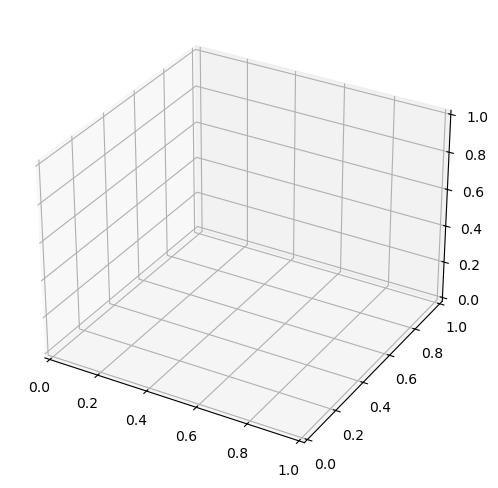

In [31]:
Surface_plot_funct(eos_data2, x, y, z, 
                   xlabel=r'$\mathcal{C}$',ylabel = '$\sigma$',zlabel = r'$e$', 
                   view2 = 240, n_col = 3, border_axes = 10)

#### Cross validation

In [32]:
#cv_results = c_val_performace_results_for_k(df2,x='C',y='sigma',z='eccentricity')
#cv_results
#optim_pol_degree = int(cv_results[cv_results['d(%)'] == cv_results['d(%)'].min()]['k'].iloc[0])
#optim_pol_degree = 5

In [33]:
cv_results_e = pd.read_csv('LOOCV_results/e_LOOCV_results.txt')
cv_results_e

MAE  Max_Error       MSE       d(%)   MAPE(%)  Explained_Variance    k
0  0.040421   0.156100  0.002398  61.983066  9.791475                 1.0  1.0
1  0.013682   0.049544  0.000288  23.570241  3.323055                 1.0  2.0
2  0.007252   0.037523  0.000080  11.369177  1.687115                 1.0  3.0
3  0.005109   0.021952  0.000038   6.138886  1.082114                 1.0  4.0
4  0.004652   0.019808  0.000033   4.576871  0.917538                 1.0  5.0
5  0.004365   0.019091  0.000030   3.985076  0.836672                 1.0  6.0
6  0.004357   0.018747  0.000029   3.896671  0.832603                 1.0  7.0
7  0.004302   0.018830  0.000029   3.754733  0.822461                 1.0  8.0

In [34]:
optim_pol_degree = 5

#### Linear regression on training data

In [35]:
df2[z_model], R_2_index, b_00, b_nm, power_comb_2, powers_2 = Regression_function(df2,x = x,y= y ,z=z, pol_degree=optim_pol_degree, 
                                        x_power = x_power,y_power = y_power)

#### $R^2$ index

In [37]:
R_2_index

0.9987303980077309

#### Relative error on training data

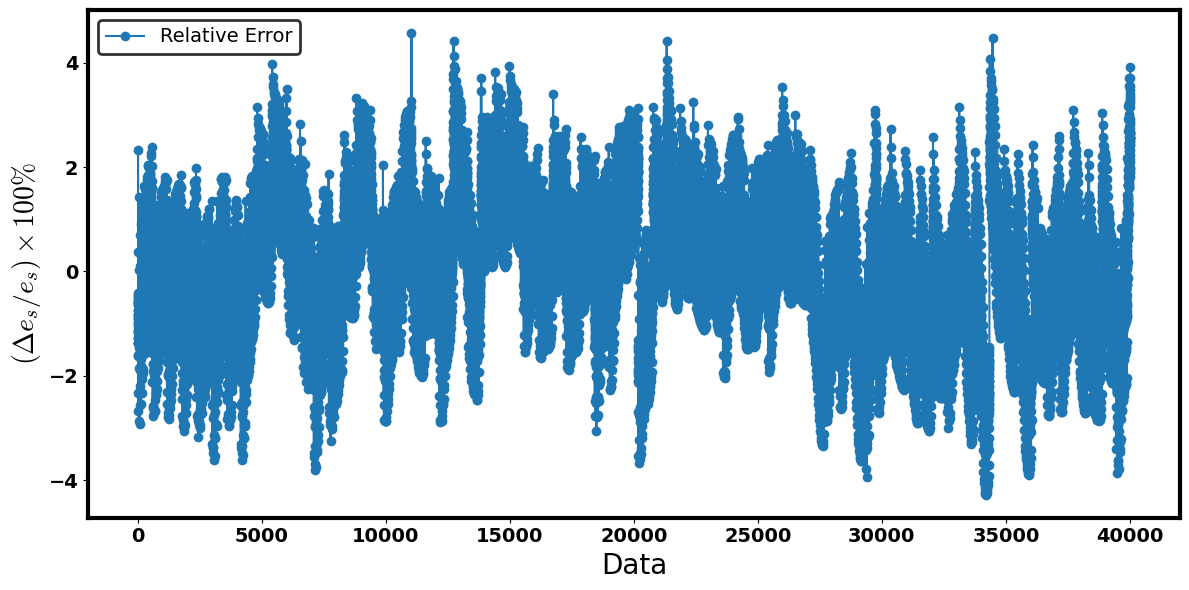

<Axes: xlabel='Data', ylabel='$(\\Delta e_s /e_s)\\times 100\\%$'>

In [38]:
relative_training_error_plot(df2, z, z_model, xlabel='Data', 
                             ylabel=r'$(\Delta e_s /e_s)\times 100\%$') 


In [39]:
training_error_funct(df2, z , z_model) 

train_Max_Error  d_max_training(%)  MAPE_taining(%)
0         0.019765           4.566042         0.917005

In [40]:
def training_relative_error_hist(data_frame, z, z_trial, xlabel, ylabel,n_bins, x1_lim, x2_lim):

    fig,ax = plt.subplots(figsize=(14, 10),)
    labels_text_size = 50
    plt.xticks(fontsize=30, fontweight="bold")
    plt.yticks(fontsize=30, fontweight="bold")

    plt.xlabel(xlabel,size=labels_text_size)
    plt.ylabel(ylabel,size=labels_text_size)

    x = (100*(-data_frame[z]+data_frame[z_trial])/data_frame[z]).hist(bins=n_bins,edgecolor ='k').autoscale(enable = True, axis = 'both', tight = True)
    
    plt.xlim(x1_lim,x2_lim)
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(4.0)

    plt.grid(False)
    plt.tight_layout()
    plt.savefig('hist.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.2)
    
    plt.show()

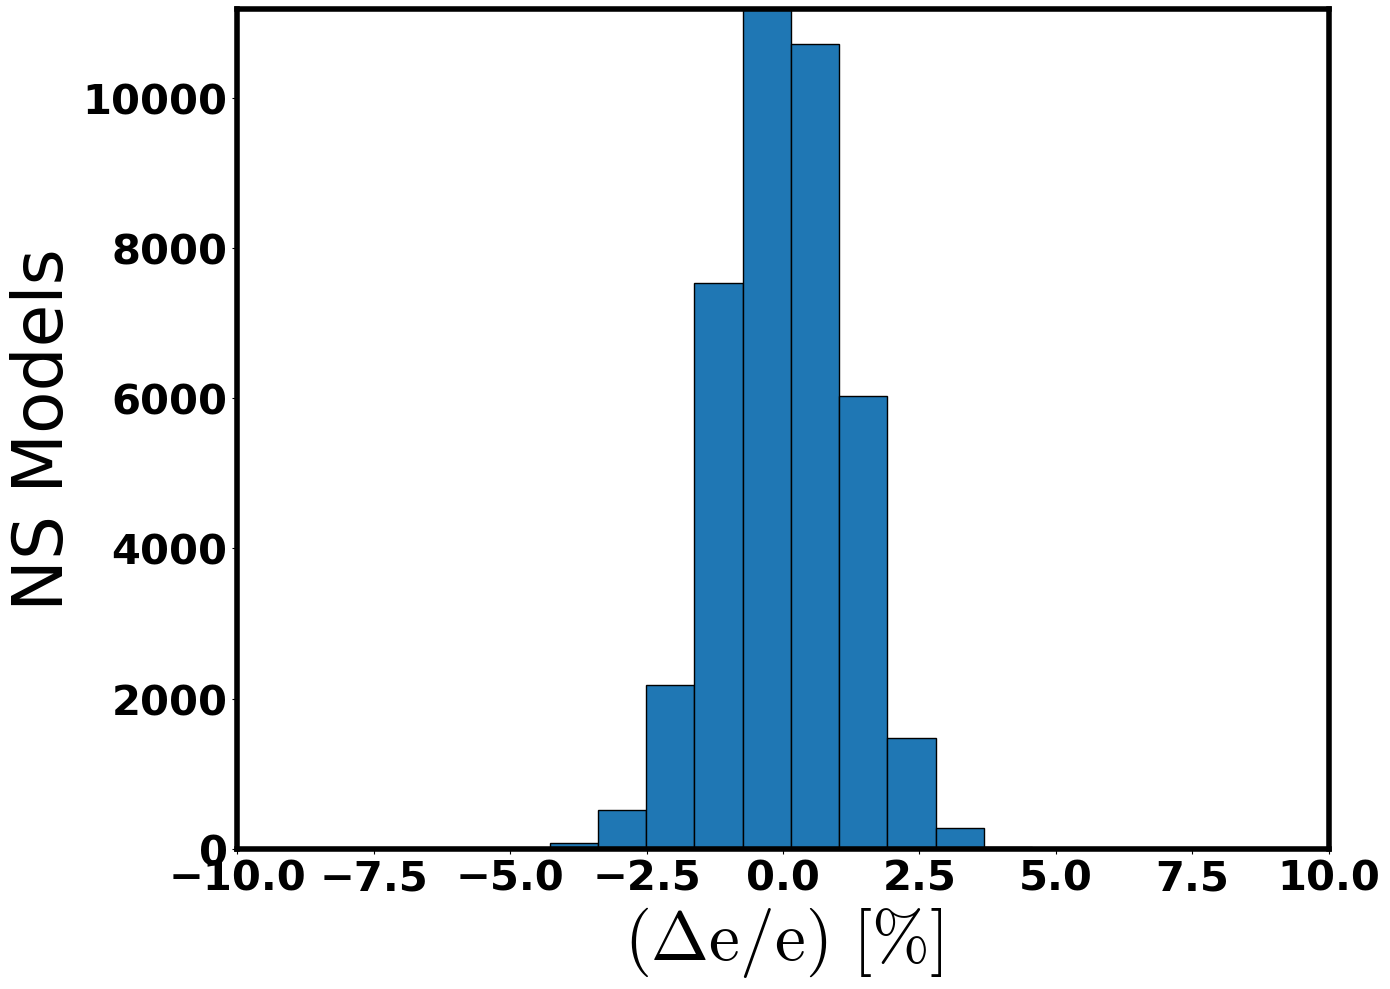

In [41]:
training_relative_error_hist(df2, z, z_model, 
                             r'$(\Delta \mathrm{e} /\mathrm{e}) \ [\%]$', r'NS Models',n_bins=10,
                             x1_lim=-10, x2_lim=10)

In [42]:
# model's intercept
b_00;
# model's other coefficients
b_nm; 
# b_nm stored to data frame
coef=pd.DataFrame(b_nm,columns=["coef"])

In [43]:
def e_funct(C,sigma):
    results=0
    for i in range(0,len(powers_2)):
        results+=(coef["coef"][i]*C**(powers_2["C"][i])*sigma**(powers_2["sigma"][i]))
      
    return b_00 + results 

In [44]:
e_funct(C_s,sigma_s)

-99.1731626257587*\mathcal{C}**5 + 68.055729822897*\mathcal{C}**4*\sigma + 137.191420601953*\mathcal{C}**4 + 12.9349885313228*\mathcal{C}**3*\sigma**2 - 57.4743082972309*\mathcal{C}**3*\sigma - 67.7948794728821*\mathcal{C}**3 - 9.03315944594449*\mathcal{C}**2*\sigma**3 + 8.0834606252312*\mathcal{C}**2*\sigma**2 + 9.19713339469666*\mathcal{C}**2*\sigma + 14.9006458417103*\mathcal{C}**2 + 4.84885244516396*\mathcal{C}*\sigma**4 - 6.44626099699597*\mathcal{C}*\sigma**3 + 2.75499036217899*\mathcal{C}*\sigma**2 - 1.33293692611052*\mathcal{C}*\sigma - 1.52533604289925*\mathcal{C} + 4.714504734503*\sigma**5 - 13.8547513636473*\sigma**4 + 15.4712200610892*\sigma**3 - 8.71280504897917*\sigma**2 + 3.04229899830747*\sigma + 0.182560763719317

In [45]:
x2 = mesh_grid_funct(3000,df2,x_name = 'C', y_name = 'sigma')[0]
y2 = mesh_grid_funct(3000,df2, x_name = 'C', y_name = 'sigma')[1]

Z2 = e_funct(x2,y2)

In [46]:
def Surface_plot_funct_2(eos_data, x,y,z, xlabel,ylabel,zlabel, view2, n_col, border_axes, X,Y,Z, l_w):

   # plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.5)
    
    fig = plt.figure(figsize=(12, 8)) 
    labels_text_size = 25
    ax = fig.add_subplot(111, projection='3d')

    dot_size = 40
    font_size = 35
    label_pad = 25
    label_size = 25


    for i in range(0, len(eos_data)):
        ax.scatter3D(eos_data[i][x].to_numpy(),eos_data[i][y].to_numpy(),eos_data[i][z].to_numpy(),
                     s=dot_size, c=c_color[i], label = eos_labels[i])    

    
    ax.plot_wireframe(X, Y, Z, rstride=40, cstride=40,edgecolor='blue' ,color = 'maroon',
                      alpha=0.8, lw = l_w, antialiased=True)

    
    
    ax.view_init(30, view2)   
    ax.set_xlabel(xlabel, fontsize=font_size, labelpad=label_pad) 
    ax.set_ylabel(ylabel, fontsize=font_size, labelpad=label_pad) 
    ax.set_zlabel(zlabel, fontsize=font_size, labelpad=label_pad) 

    ax.zaxis.labelpad = 12 
    #ax.zaxis._axinfo['label']['space_factor'] = 10.0
    #ax.yaxis._axinfo['label']['space_factor'] = 1.0   
    #ax.xaxis._axinfo['label']['space_factor'] = 1.0   


    
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.zaxis.set_tick_params(labelsize=label_size)

    ax.zaxis.labelpad = 1
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.line.set_linewidth(3)
    
    ax.grid(False)


    #leg = plt.legend(loc="best",ncol=n_col, borderaxespad=border_axes, prop={'size': 10}, shadow=True, fontsize="large", bbox_to_anchor=(1,1))    #,bbox_to_anchor=(1,1)
    #leg.get_frame().set_linewidth(1.0)
    #leg.get_frame().set_edgecolor('black')
    
    plt.tight_layout()

    #plt.savefig('e_C_sigma.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.2)
    plt.show()

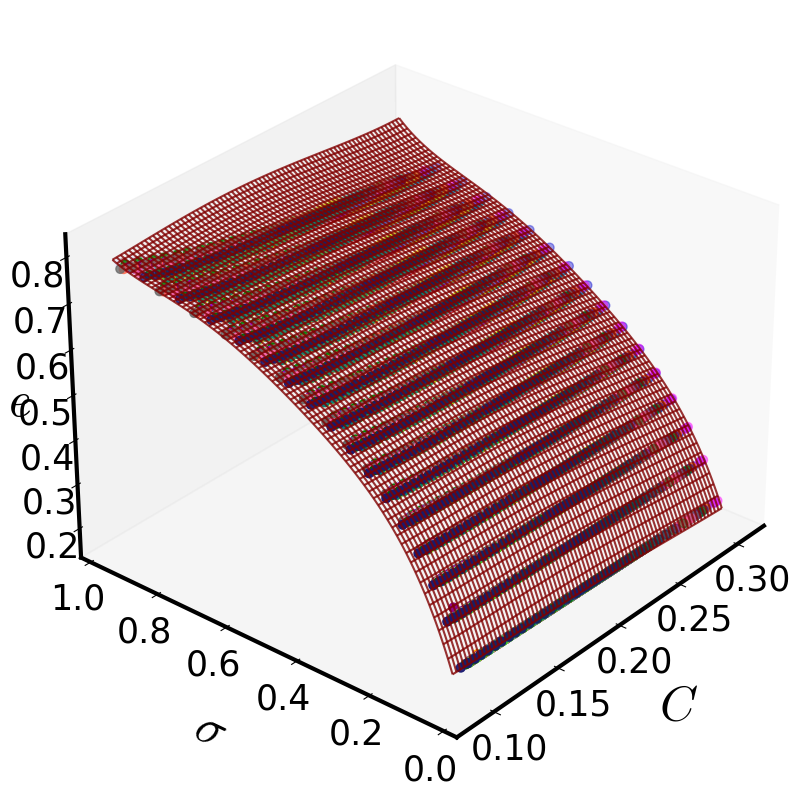

In [50]:
Surface_plot_funct_2(eos_data2, x, y, z, xlabel=r'$C$',ylabel='$\sigma$',zlabel=r'$e$', 
                     view2=220, n_col=3, border_axes=8, X=x2,Y=y2,Z=Z2, l_w=0.5)

### Fitting function's percentage error distribution

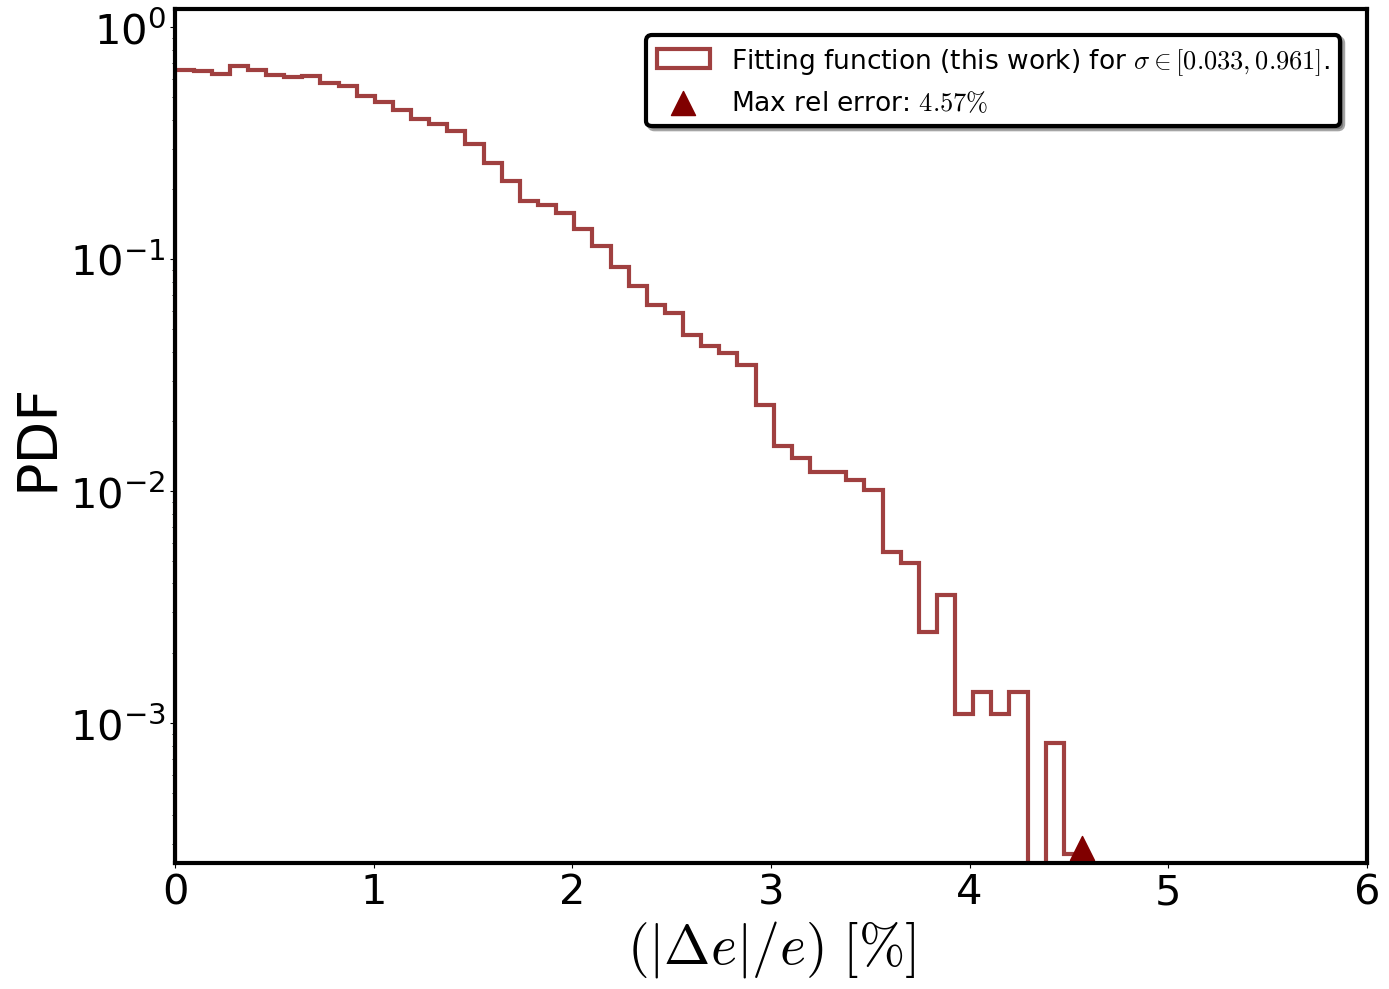

In [53]:
fig,ax = plt.subplots(figsize=(14, 10),)
labels_text_size = 40
plt.xticks(fontsize=30) #fontweight="bold"
plt.yticks(fontsize=30)

xlabel = r'$(|\Delta e| /e) \ [\%]$'
#ylabel = r'Rotating NSs PDF'
ylabel = r'PDF'


plt.xlabel(xlabel,size=labels_text_size)
plt.ylabel(ylabel,size=labels_text_size)


#bins = np.logspace(np.log10(1e-4), np.log10(20), 50)

bins = 50
alpha = 0.75

y_reg_model = (np.abs(100*(-df2[z] + df2[z_model])/df2[z])).hist(
    density=True, 
    bins=bins, 
    lw=3, 
    edgecolor='maroon', 
    zorder=1, 
    histtype='step', 
    alpha=alpha, 
    label=f"Fitting function (this work) for $ \sigma \in[{np.round(df2['sigma'].min(), 3)}, {np.round(df2['sigma'].max(), 3)}]$.", 
    color='maroon',
    #log = True
).autoscale(enable=True, axis='both', tight=True)


vertical_lines = [4.5660]  # Adjust these values based on your requirements
# Add star symbol to mark the first point on the x-axis (at 4.5660%)
plt.scatter(vertical_lines[0], 2.9e-4, color='maroon',  marker='^', s=300, zorder=2, label=r'Max rel error: $ 4.57 \%$')  # Star marker

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3.)


plt.yscale('log')
plt.xlim(0,6)
plt.ylim(2.5e-4,1.2)

plt.grid(False)
leg = plt.legend(loc="upper right",ncol=1, borderaxespad=1, prop={'size': 19}, shadow=True, fontsize="large")    #,bbox_to_anchor=(1,1)
leg.get_frame().set_linewidth(3.0)
leg.get_frame().set_edgecolor('black')

plt.tight_layout()
plt.show()

#### Universal relation for $\mathcal{R} = R_p/R_{eq}$ (All NSs included)

In [54]:
x = 'C'; y = 'sigma'; z = 'Rpol/Req'; z_model = 'Rpol/Req_model'; x_power = 'C'; y_power = 'sigma'; #Rpol/Req

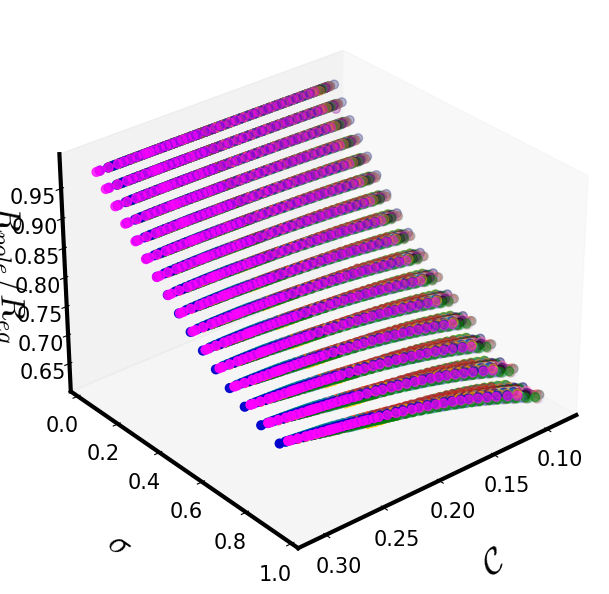

In [55]:
Surface_plot_funct(eos_data2, x, y, z, 
                   xlabel=r'$\mathcal{C}$',ylabel = '$\sigma$',zlabel = r'$R_{pole}/R_{eq}$', 
                   view2 = 50, n_col = 3, border_axes = 10)

#### Cross-Validation

In [56]:
#cv_results = c_val_performace_results_for_k(df,x='C',y='sigma',z='Rpol/Req')
#cv_results
#optim_pol_degree = int(cv_results[cv_results['d(%)'] == cv_results['d(%)'].min()]['k'].iloc[0])

In [57]:
cv_results_R = pd.read_csv('LOOCV_results/Rpol_Req_LOOCV_results.txt')
cv_results_R

MAE  Max_Error       MSE       d(%)   MAPE(%)  Explained_Variance    k
0  0.011254   0.068301  0.000196  10.826695  1.401666                 1.0  1.0
1  0.003819   0.027850  0.000025   4.414587  0.489926                 1.0  2.0
2  0.003213   0.019550  0.000019   3.117947  0.421023                 1.0  3.0
3  0.003112   0.018761  0.000019   2.801806  0.409053                 1.0  4.0
4  0.003089   0.019980  0.000019   2.948913  0.405631                 1.0  5.0
5  0.003067   0.020069  0.000018   2.962009  0.402397                 1.0  6.0
6  0.003043   0.020626  0.000018   3.152602  0.398805                 1.0  7.0
7  0.003014   0.020130  0.000018   3.076814  0.394644                 1.0  8.0

In [71]:
optim_pol_degree = 4

#### LInear regression on training data

In [72]:
df[z_model], R_2_index, C_00, C_nm, pow_comb_3, powers_3 = Regression_function(df,x = x,y= y ,z=z, pol_degree=optim_pol_degree, 
                                        x_power = x_power,y_power = y_power)

##### $R^2$ index

In [73]:
 R_2_index

0.9983153014546605

#### Relative error on training data

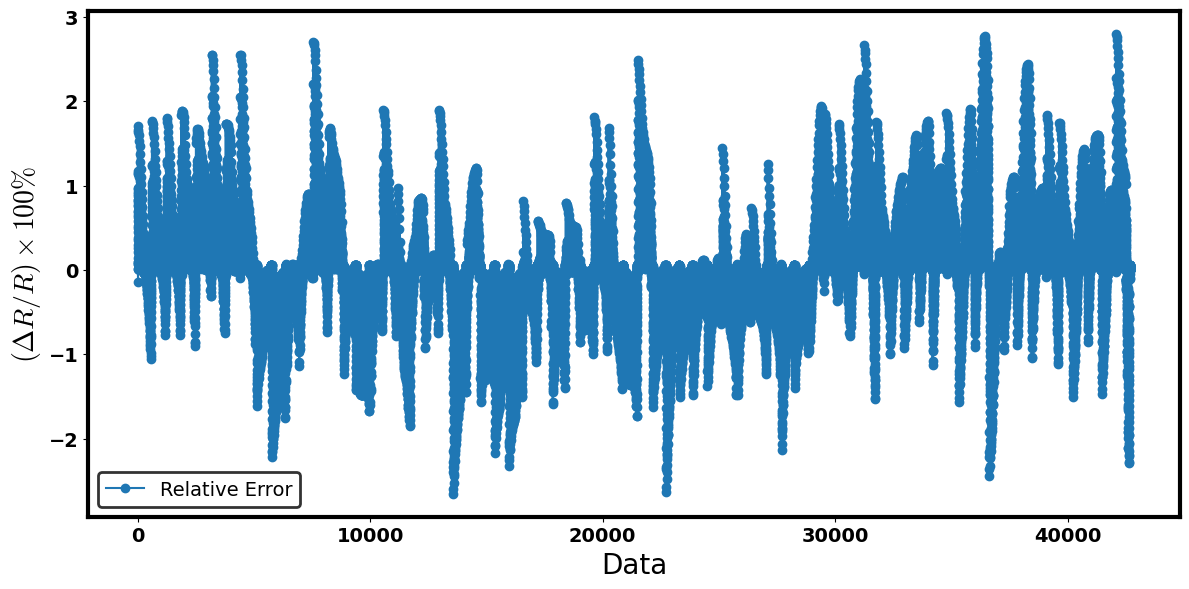

<Axes: xlabel='Data', ylabel='$(\\Delta R /R)\\times 100\\%$'>

In [74]:
relative_training_error_plot(df, z, z_model, xlabel='Data', 
                             ylabel=r'$(\Delta R /R)\times 100\%$') #,fig_title = 'test.png'

In [75]:
training_error_funct(df, z, z_model) 

train_Max_Error  d_max_training(%)  MAPE_taining(%)
0         0.018748           2.795446         0.408883

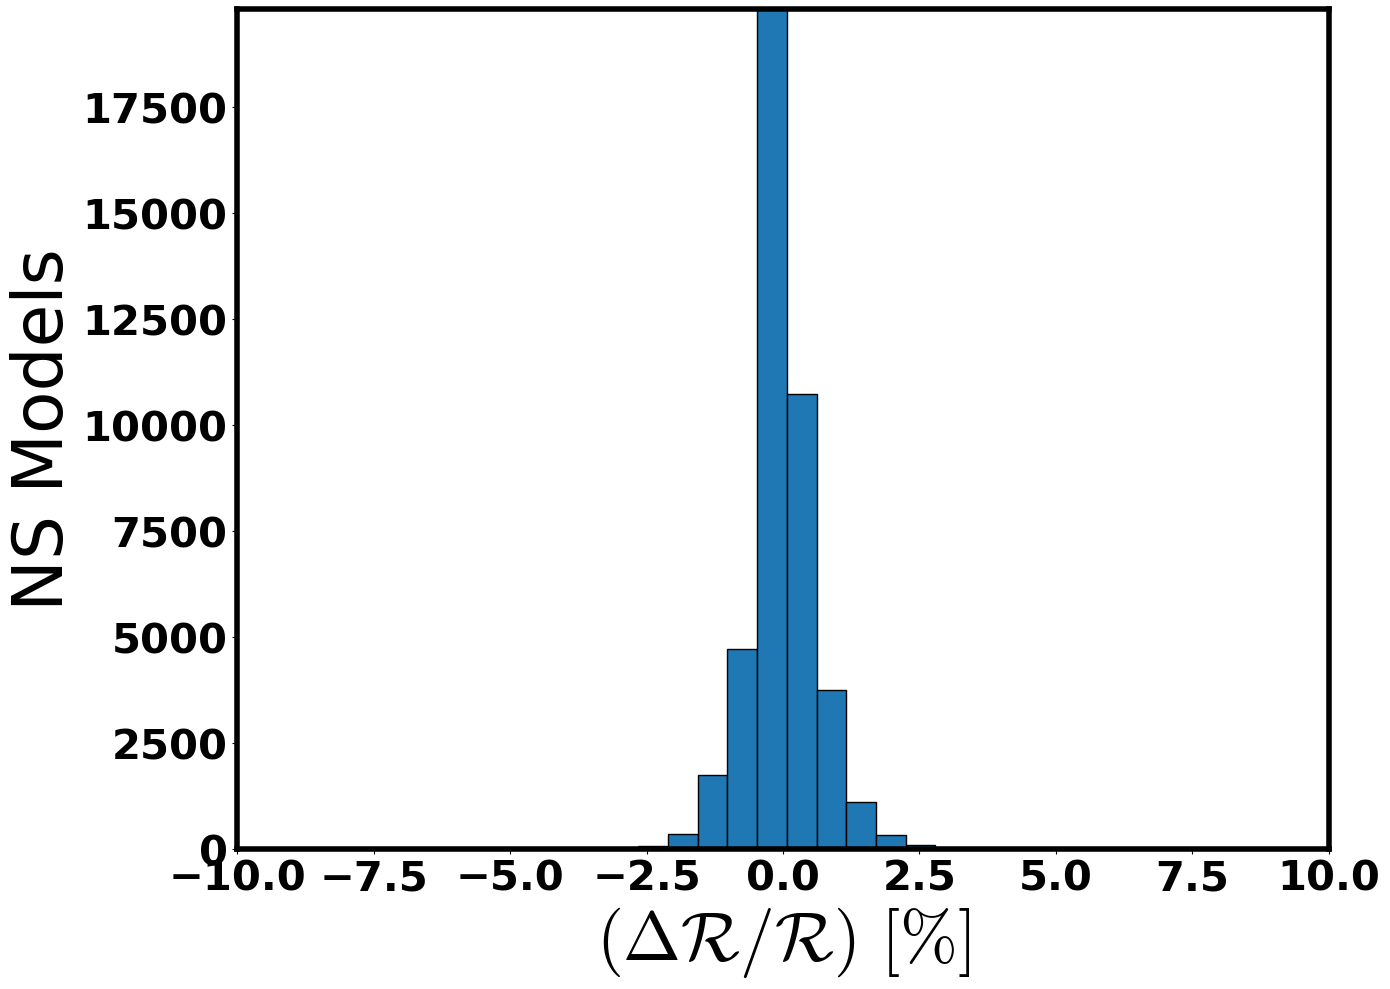

In [76]:
training_relative_error_hist(df,z, z_model, 
                             r'$(\Delta \mathcal{R} /\mathcal{R}) \ [\%]$', r'NS Models',n_bins=10,
                             x1_lim=-10, x2_lim=10)

In [77]:
#df['rel_error'] = 100*(df[z_model] - df[z])/df[z]

In [78]:
# model's intercept
C_00;
# model's other coefficients
C_nm;
# C_nm stored to data frame
coef=pd.DataFrame(C_nm,columns=["coef"])

In [79]:
def R_funct(C,sigma):
    results=0
    for i in range(0,len(powers_3)):
        results+=(coef["coef"][i]*C**(powers_3["C"][i])*sigma**(powers_3["sigma"][i]))
      
    return C_00 + results 

In [80]:
R_funct(C_s,sigma_s)

-45.3015234274801*\mathcal{C}**4 - 7.52466249012259*\mathcal{C}**3*\sigma + 36.1318805958812*\mathcal{C}**3 - 2.50668582910242*\mathcal{C}**2*\sigma**2 + 8.66838156199219*\mathcal{C}**2*\sigma - 10.4561101976216*\mathcal{C}**2 + 0.527775373801867*\mathcal{C}*\sigma**3 - 0.226904263928412*\mathcal{C}*\sigma**2 - 1.45892092679705*\mathcal{C}*\sigma + 1.29663161750561*\mathcal{C} + 0.196118434593753*\sigma**4 - 0.440968195037673*\sigma**3 + 0.544639042230603*\sigma**2 - 0.617710700567153*\sigma + 0.942328028476575

In [88]:
x3 = mesh_grid_funct(1500,df,x_name = 'C', y_name = 'sigma')[0]
y3 = mesh_grid_funct(1500,df, x_name = 'C', y_name = 'sigma')[1]

Z3 = R_funct(x3,y3)

In [89]:
def Surface_plot_funct_2(eos_data, x,y,z, xlabel,ylabel,zlabel, view2, n_col, border_axes, X,Y,Z, l_w):

   # plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.5)
    
    fig = plt.figure(figsize=(12, 8)) 
    labels_text_size = 25
    ax = fig.add_subplot(111, projection='3d')

    dot_size = 40
    font_size = 30
    label_pad = 20
    label_size = 20

    for i in range(0, len(eos_data)):
        ax.scatter3D(eos_data[i][x].to_numpy(),eos_data[i][y].to_numpy(),eos_data[i][z].to_numpy(),
                     s=dot_size, c=c_color[i])  #, label = eos_labels[i]  

    
    ax.plot_wireframe(X, Y, Z, rstride=40, cstride=40,edgecolor='blue' ,color = 'maroon',
                      alpha=0.8, zorder = 15, lw = l_w, antialiased=True)
    
    
    
    ax.view_init(30, view2)   
    ax.set_xlabel(xlabel, fontsize=font_size, labelpad=label_pad) 
    ax.set_ylabel(ylabel, fontsize=font_size, labelpad=label_pad) 
    ax.zaxis.set_rotate_label(False) 
    ax.set_zlabel(zlabel, fontsize=font_size, labelpad=label_pad, rotation=0) 

    
    ax.zaxis.labelpad = 6
    

    #ax.zaxis._axinfo['label']['space_factor'] = 10.0
    #ax.yaxis._axinfo['label']['space_factor'] = 1.0   
    #ax.xaxis._axinfo['label']['space_factor'] = 1.0   


    
    ax.xaxis.set_tick_params(labelsize=label_size-4)
    ax.yaxis.set_tick_params(labelsize=label_size-4)
    ax.zaxis.set_tick_params(labelsize=label_size-5)
    
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.line.set_linewidth(2)
    
    ax.grid(False)


    #leg = plt.legend(loc="lower left",ncol=n_col, borderaxespad=border_axes, prop={'size': 20}, shadow=True, fontsize="large")    #,bbox_to_anchor=(1,1)
    #leg.get_frame().set_linewidth(1.0)
    #leg.get_frame().set_edgecolor('black')
    
    plt.tight_layout()

    #plt.savefig('R_C_sigma_2.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.2)
    plt.show()

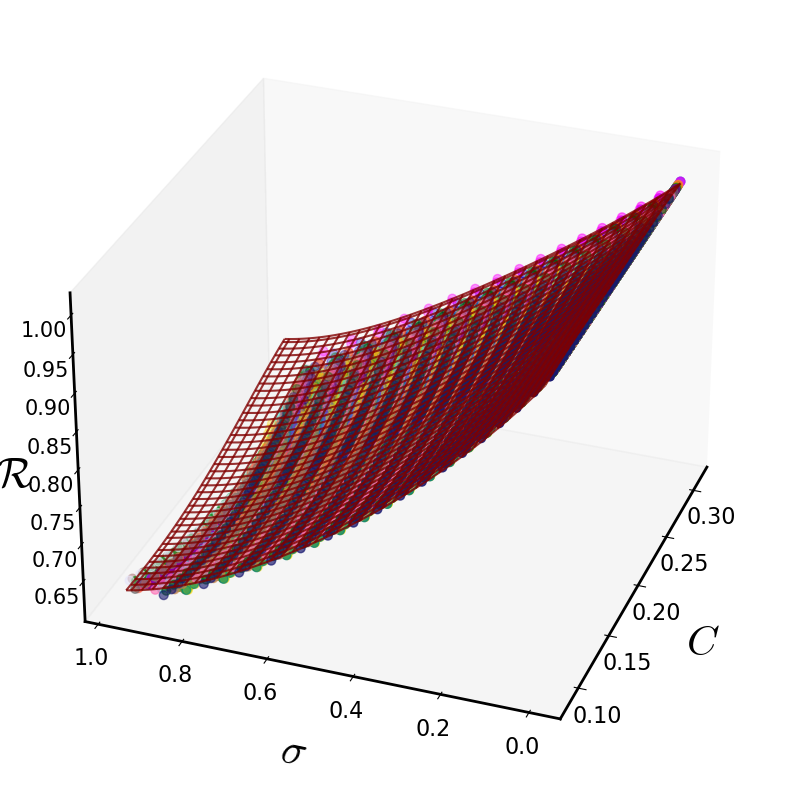

In [90]:
Surface_plot_funct_2(eos_data, x, y, z, xlabel=r'$C$',ylabel='$\sigma$',zlabel=r'$\mathcal{R}$', 
                     view2=200, n_col=1, border_axes=1, X=x3,Y=y3,Z=Z3, l_w=1.5)


### Fractional difference distribution

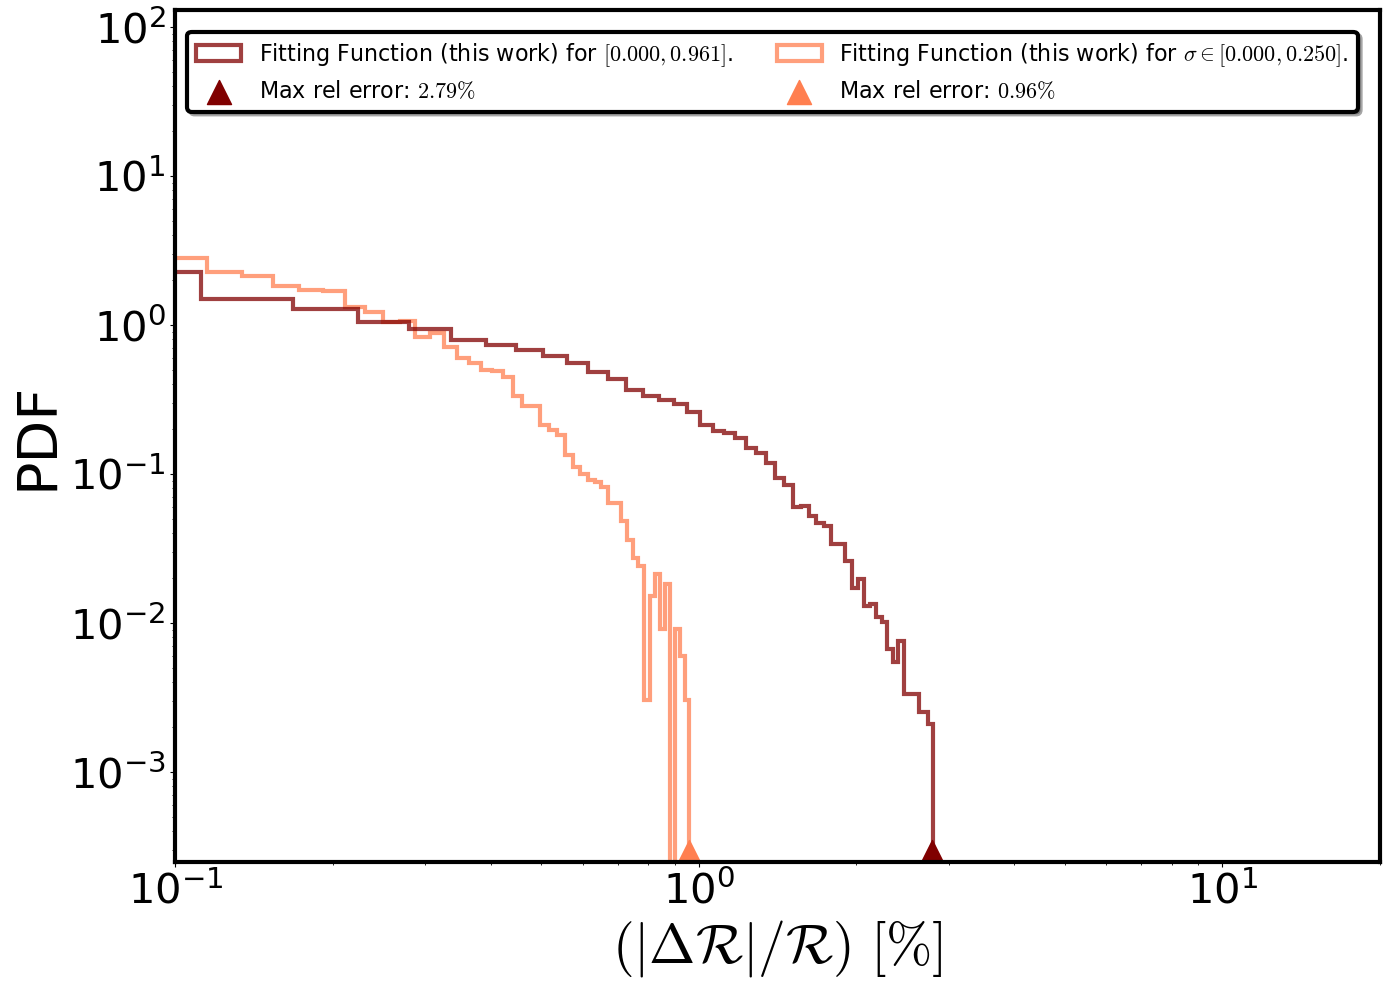

In [91]:
fig,ax = plt.subplots(figsize=(14, 10),)
labels_text_size = 40
plt.xticks(fontsize=30) #fontweight="bold"
plt.yticks(fontsize=30)


xlabel = r'$(|\Delta \mathcal{R}| /\mathcal{R}) \ [\%]$'
ylabel = r'PDF'

plt.xlabel(xlabel,size=labels_text_size)
plt.ylabel(ylabel,size=labels_text_size)

bins = 50
alpha = 0.75

y_reg_model = abs(100*(-df[z]+df[z_model])/df[z]).hist(
    #log = True,
    density = True,
    bins=bins,
    lw = 3,
    edgecolor ='maroon', 
    histtype='step', 
    alpha = alpha, 
    label = f"Fitting Function (this work) for $[0.000, {np.round(df['sigma'].max(), 3)}]$.", 
    color = 'maroon').autoscale(enable = True, axis = 'both', tight = True)


vertical_lines = [2.79] 
plt.scatter(vertical_lines[0], 2.9e-4, color='maroon',  marker='^', s=300, zorder=2, label=r'Max rel error: $ 2.79 \%$')  # Star marker

y_reg_less_0_25 = abs(100*(-df[df['sigma']<=0.25][z]+df[df['sigma']<=0.25][z_model])/df[df['sigma']<=0.25][z]).hist(
    #log = True,
    density = True,
    bins=bins,
    edgecolor ='coral',
    lw = 3,
    histtype='step', 
    zorder = 1, 
    alpha = alpha,
    label = f"Fitting Function (this work) for $\sigma \in[0.000, 0.250]$.",
    color = 'coral').autoscale(enable = True, axis = 'both', tight = True)


vertical_lines = [0.9581596145435877, None]  # Adjust these values based on your requirements
plt.scatter(vertical_lines[0], 2.9e-4, color='coral',  marker='^', s=300, zorder=2, label=r'Max rel error: $ 0.96 \%$')  # Star marker




plt.yscale('log')
plt.xscale('log')


plt.xlim(1.e-1,20)
plt.ylim(2.5e-4,130)



for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3.0)

plt.grid(False)
leg = plt.legend(loc="upper right",ncol=2, borderaxespad=1, prop={'size': 16}, shadow=True, fontsize="large")    #,bbox_to_anchor=(1,1)
leg.get_frame().set_linewidth(3.0)
leg.get_frame().set_edgecolor('black')


#plt.xlim(1e-1,15)

plt.tight_layout()
#plt.savefig('R_c_sigma_hist_2.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.2)
plt.show()

### slowly rotating case

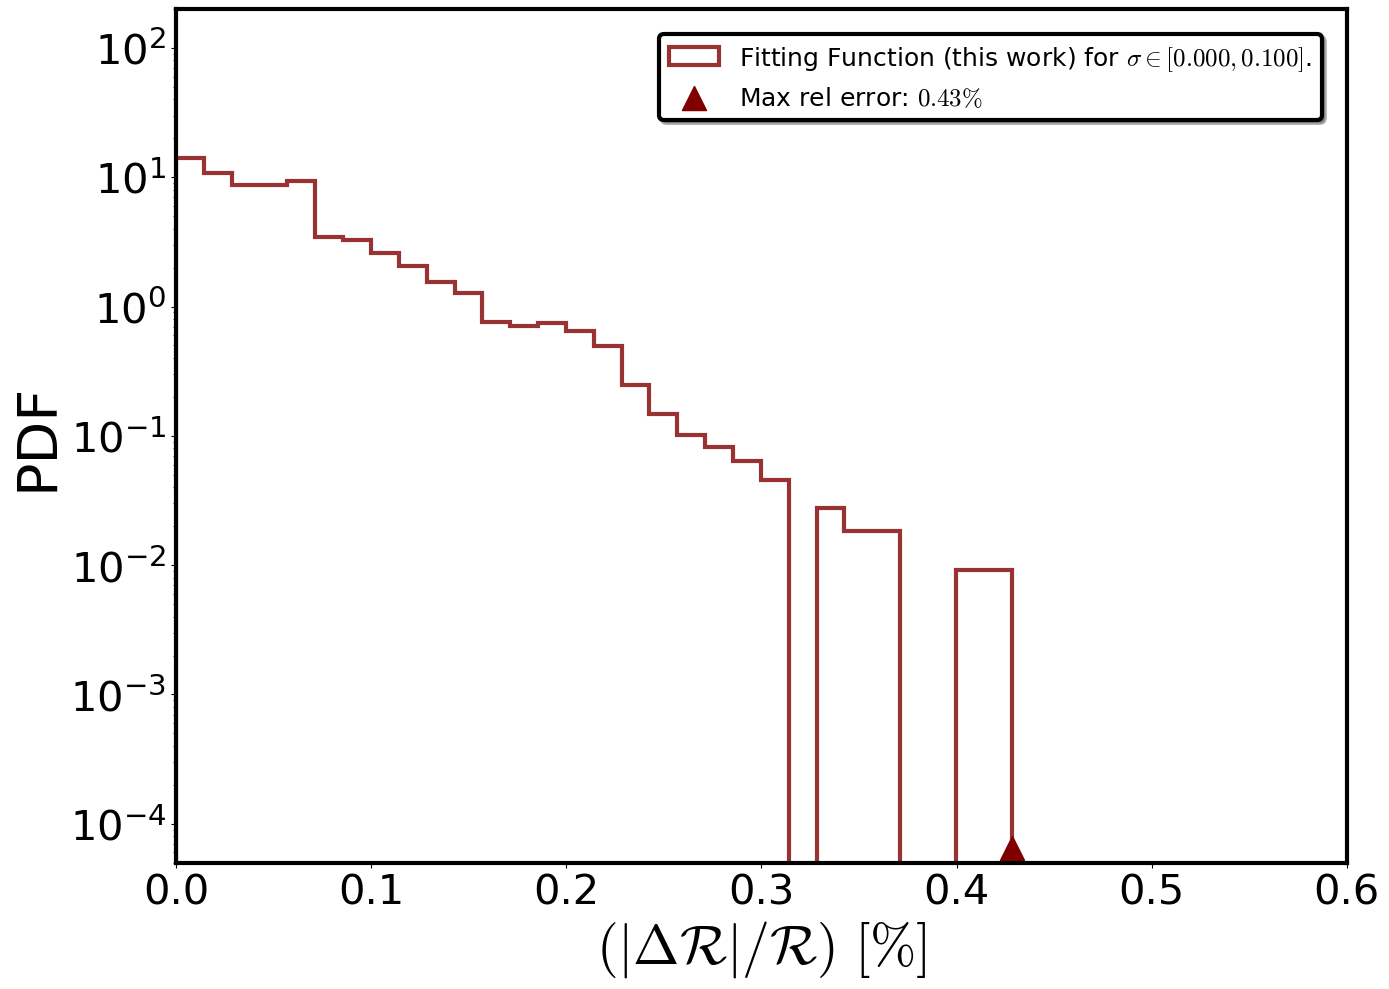

In [93]:
fig,ax = plt.subplots(figsize=(14, 10),)
labels_text_size = 40
plt.xticks(fontsize=30) #fontweight="bold"
plt.yticks(fontsize=30)


xlabel = r'$(|\Delta \mathcal{R}| /\mathcal{R}) \ [\%]$'
ylabel = f'PDF'

plt.xlabel(xlabel,size=labels_text_size)
plt.ylabel(ylabel,size=labels_text_size)

bins = 50
alpha = 0.8
y_reg_0_1_model = abs(100*(-df[df['sigma']<=0.1][z]+df[df['sigma']<=0.1][z_model])/df[df['sigma']<=0.1][z]).hist(
                    density = True,
                    bins=bins-20,
                    lw=3, 
                    edgecolor ='maroon', 
                    zorder = 1, 
                    histtype='step',
                    alpha = alpha,
                    label = f'Fitting Function (this work) for $\sigma \in[0.000, 0.100]$.', color = 'maroon').autoscale(enable = True, axis = 'both', tight = True)


vertical_lines_reg_0_1 = [0.42818322]  # Adjust these values based on your requirements
plt.scatter(vertical_lines_reg_0_1[0], 0.65e-4, color='maroon',  marker='^', s=300, zorder=2, label=r'Max rel error: $ 0.43 \%$')  # Star marker

plt.yscale('log')
#plt.xscale('log')

plt.ylim(0.5e-4,200)
plt.xlim(0,0.6)


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3.0)

plt.grid(False)
leg = plt.legend(loc="upper right",ncol=1, borderaxespad=1, prop={'size': 18}, shadow=True, fontsize="large")    #,bbox_to_anchor=(1,1)
leg.get_frame().set_linewidth(3.0)
leg.get_frame().set_edgecolor('black')
    
plt.tight_layout()
#plt.savefig('R_reg_vs_alg_model.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.2)
plt.show()

### Static limit

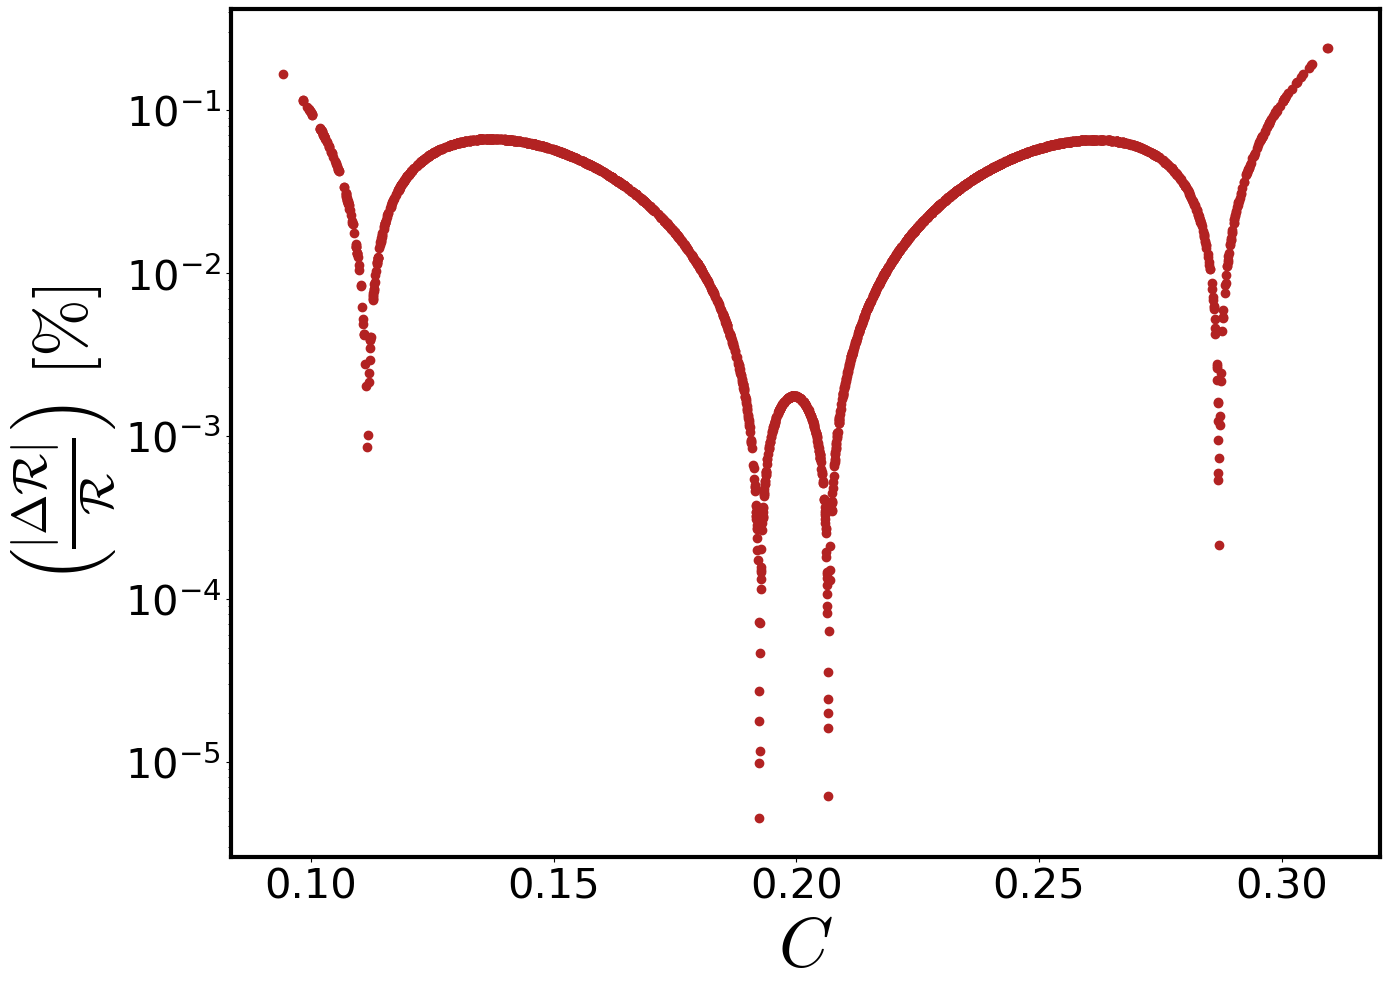

In [94]:
fig,ax = plt.subplots(figsize=(14, 10),)  

labels_text_size = 50
plt.xticks(fontsize=30) 
plt.yticks(fontsize=30)

plt.xlabel(r'$C$',size=labels_text_size)
#plt.ylabel(r'Relative error',size=labels_text_size)
plt.ylabel(r'$ \left(\frac{|\Delta \mathcal{R}|}{\mathcal{R}}\right) \ [\%]$',size=labels_text_size)


plt.scatter(df_static['C'],100*abs((R_funct(df_static['C'],0))-df_static['Rpol/Req'])/df_static['Rpol/Req'], color = 'firebrick')  



for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3.0)


plt.yscale('log')

plt.tight_layout()
#plt.savefig('DR_s_C_no_sigma.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.2)

plt.show()


In [95]:
(100*abs((R_funct(df_static['C'],0))-df_static['Rpol/Req'])/df_static['Rpol/Req']).max()

0.24219577943114245

### Universal relation for $g_{pole}$ (All stars included)

In [96]:
x = 'C'; y = 'sigma'; z = 'g_pole_scaled' ; z_model = 'g_pole_scaled_model'; x_power = 'C'; y_power = 'sigma';

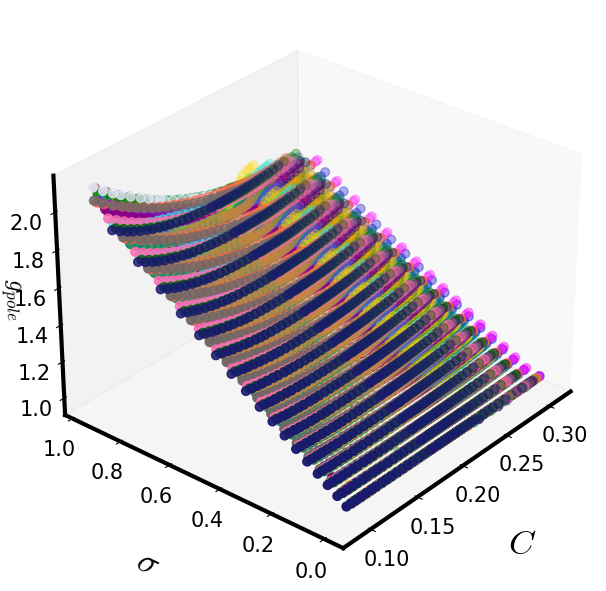

In [97]:
Surface_plot_funct(eos_data, x,y,z, 
                   xlabel=r'$C$',ylabel = r'$\sigma$',zlabel = r'$\frac{g_{pole}}{g_0}$', 
                   view2 = 220, n_col = 5, border_axes = 10)

#### Cross-validation

In [98]:
#cv_results = c_val_performace_results_for_k(df,x=x,y=y,z=z)
#cv_results
#optim_pol_degree = int(cv_results[cv_results['d(%)'] == cv_results['d(%)'].min()]['k'].iloc[0])


In [99]:
cv_results_g_p = pd.read_csv('LOOCV_results/g_pole_LOOCV_results.txt')
cv_results_g_p 

MAE  Max_Error       MSE      d(%)   MAPE(%)  Explained_Variance    k
0  0.015713   0.146115  0.000430  6.934889  1.176683                 1.0  1.0
1  0.005539   0.078188  0.000072  4.101918  0.384596                 1.0  2.0
2  0.004535   0.062011  0.000056  3.253231  0.303176                 1.0  3.0
3  0.004320   0.053770  0.000052  3.073449  0.286016                 1.0  4.0
4  0.004268   0.051413  0.000051  3.058724  0.282789                 1.0  5.0
5  0.004222   0.053163  0.000050  2.967900  0.280160                 1.0  6.0
6  0.004171   0.055593  0.000049  3.096514  0.277813                 1.0  7.0
7  0.004090   0.057886  0.000047  3.224207  0.272419                 1.0  8.0

In [102]:
optim_pol_degree = 4

#### Linear regression on training data

In [103]:
df[z_model], R_2_index, D_00, D_nm, pow_comb_4, powers_4 = Regression_function(df,x = x,y= y ,z=z, 
                                                  pol_degree=optim_pol_degree, x_power = x_power,
                                                  y_power = y_power)

#### $R^2$ index

In [104]:
R_2_index

0.9991471134868862

#### Relative error on training data

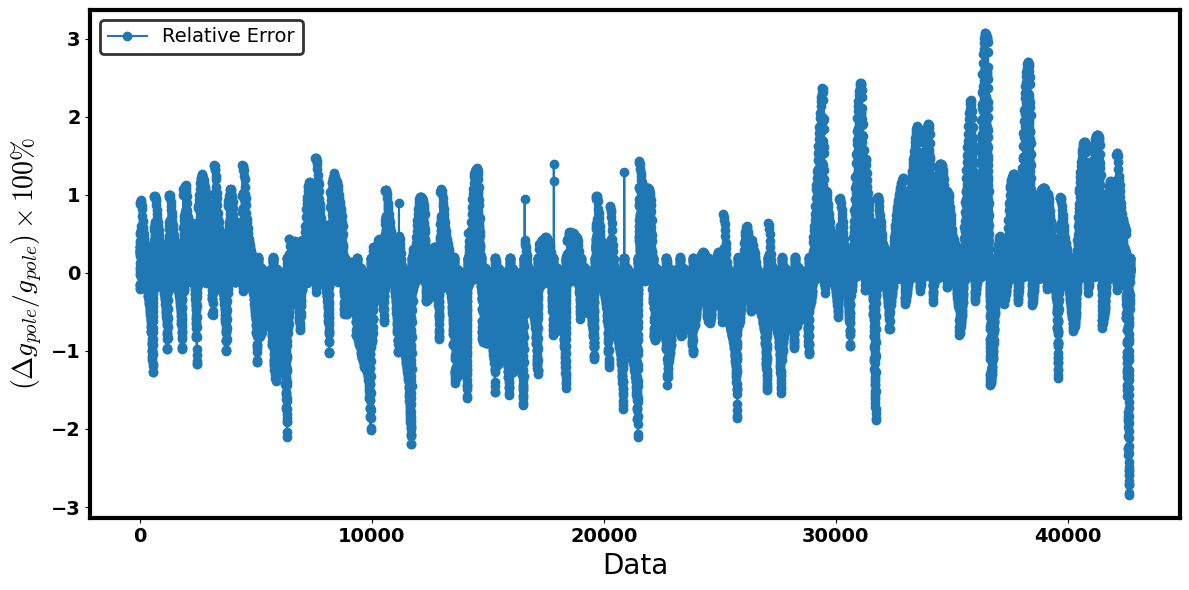

<Axes: xlabel='Data', ylabel='$(\\Delta g_{pole} /g_{pole})\\times 100\\%$'>

In [105]:
relative_training_error_plot(df, z ,z_model, xlabel='Data', 
                             ylabel=r'$(\Delta g_{pole} /g_{pole})\times 100\%$') 


In [106]:
training_error_funct(df, z , z_model)

train_Max_Error  d_max_training(%)  MAPE_taining(%)
0         0.053696           3.070872         0.285889

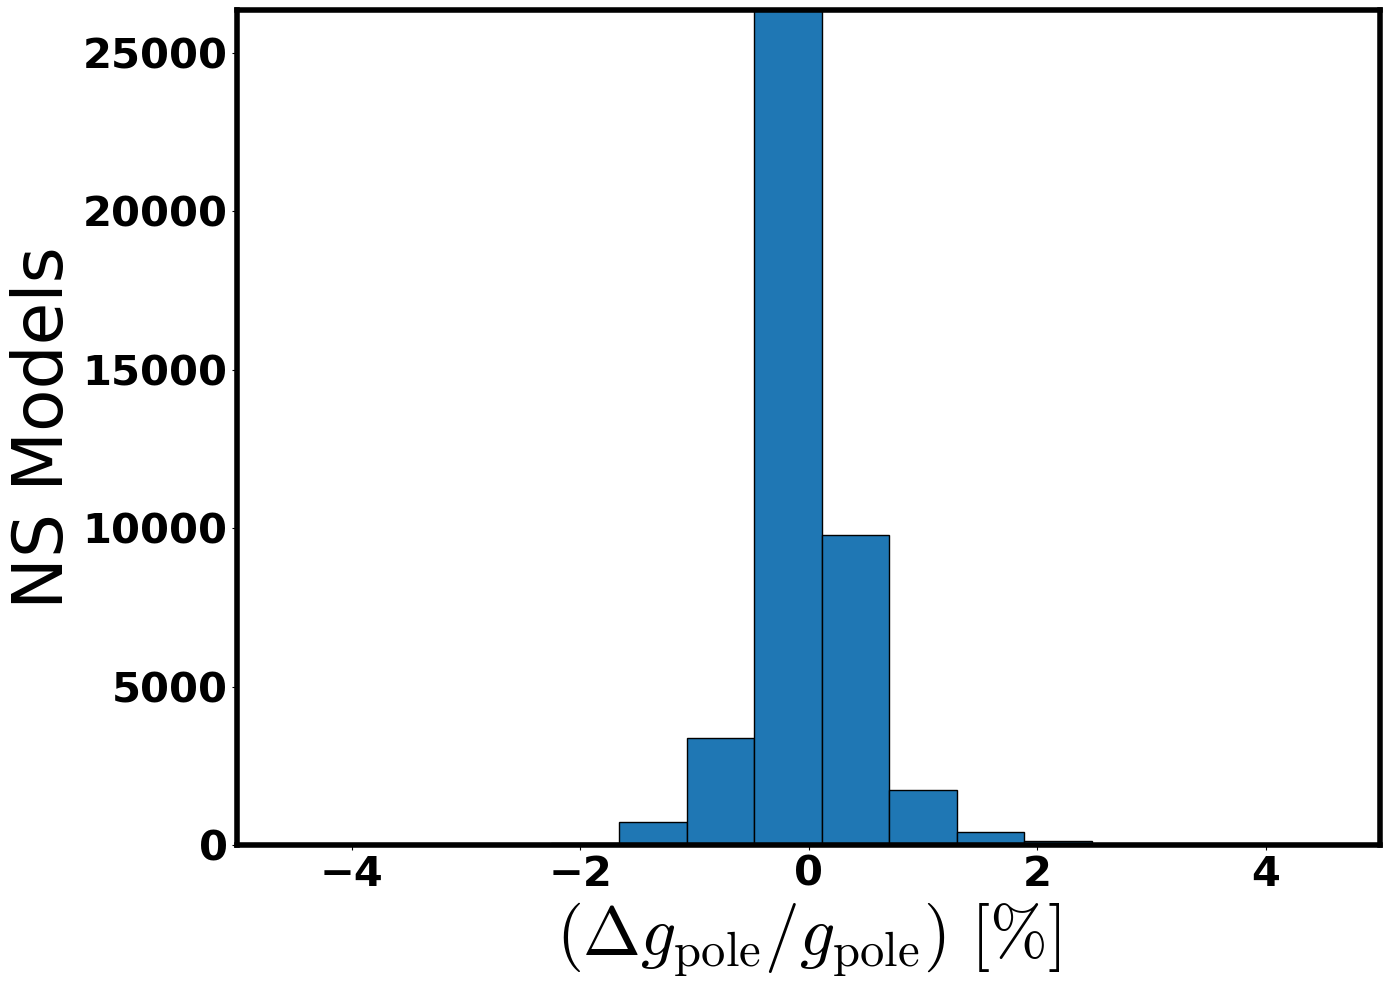

In [107]:
training_relative_error_hist(df, z , z_model, 
                             r'$(\Delta g_{\mathrm{pole}} /g_{\mathrm{pole}}) \ [\%]$', r'NS Models',n_bins=10,
                             x1_lim=-5, x2_lim=5)

### Fractional difference distribution

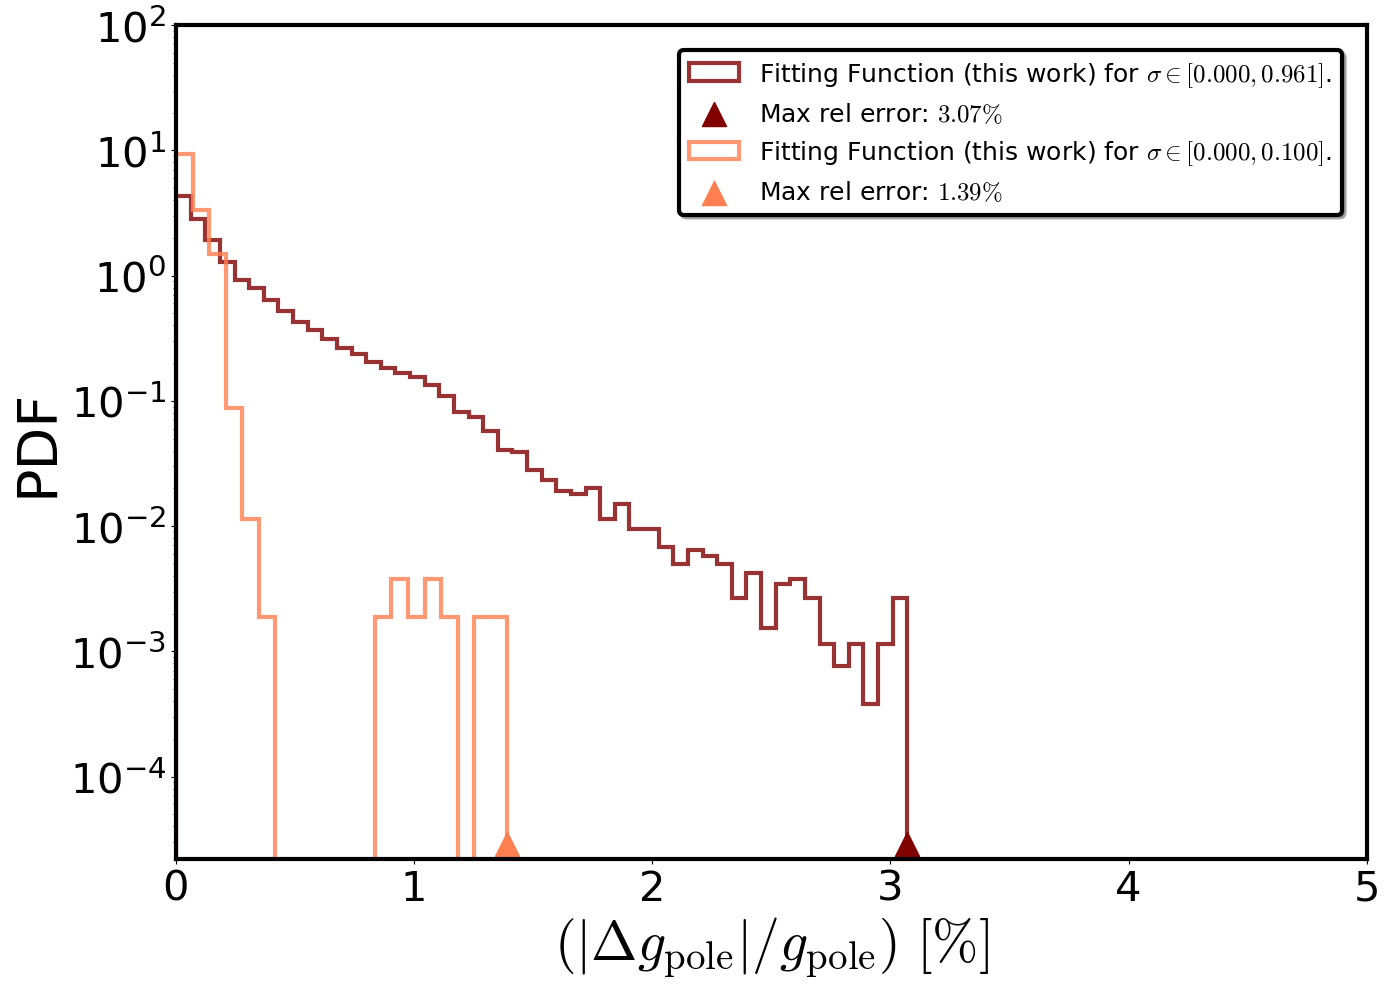

In [108]:
fig,ax = plt.subplots(figsize=(14, 10),)
labels_text_size = 40
plt.xticks(fontsize=30) # fontweight="bold"
plt.yticks(fontsize=30)

xlabel = r'$(|\Delta g_{\mathrm{pole}}| /g_{\mathrm{pole}}) \ [\%]$'
#ylabel = 'NSs PDF'
ylabel = 'PDF'

plt.xlabel(xlabel,size=labels_text_size)
plt.ylabel(ylabel,size=labels_text_size)

bins = 50
alpha = 0.8

y_reg_grav_model = abs(100*(-df[z]+df[z_model])/df[z]).hist(
                    density = True,
                    lw = 3,
                    bins=bins,
                    edgecolor ='maroon',
                    histtype='step',
                    zorder = 1, 
                    label = f"Fitting Function (this work) for $\sigma \in[0.000, {np.round(df['sigma'].max(), 3)}]$.", 
                    alpha = alpha,
                    color = 'maroon').autoscale(enable = True, axis = 'both', tight = True)


vertical_lines = [3.070871712452435]  # Adjust these values based on your requirements
plt.scatter(vertical_lines[0], 2.9e-5, color='maroon',  marker='^', s=300, zorder=2, label=r'Max rel error: $ 3.07 \%$')  # Star marker


y_reg_grav_model = abs(100*(-df[df['sigma']<=0.1][z]+df[df['sigma']<=0.1][z_model])/df[df['sigma']<=0.1][z]).hist(
                    density = True,
                    lw = 3,
                    bins=bins-30,
                    edgecolor ='coral',
                    histtype='step',
                    zorder = 1, 
                    label = r"Fitting Function (this work) for $\sigma \in[0.000, 0.100]$.", 
                    alpha = alpha,
                    color = 'coral').autoscale(enable = True, axis = 'both', tight = True)


vertical_lines = [1.391]  # Adjust these values based on your requirements
plt.scatter(vertical_lines[0], 2.9e-5, color='coral',  marker='^', s=300, zorder=2, label=r'Max rel error: $ 1.39 \%$')  # Star marker


plt.yscale('log')
plt.xlim(0,5)

plt.ylim(2.2e-5,100)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3.0)

plt.grid(False)
leg = plt.legend(loc="upper right",ncol=1, borderaxespad=1, prop={'size': 18}, shadow=True, fontsize="large")    #,bbox_to_anchor=(1,1)
leg.get_frame().set_linewidth(3.0)
leg.get_frame().set_edgecolor('black')
    
plt.tight_layout()
#plt.savefig('g_p_c_sigma_hist.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.2)
plt.show()



### Model's coefficients

In [110]:
# model's intercept
D_00; 
# model's other coefficients
D_nm;
# D_nm stored to data frame
coef=pd.DataFrame(D_nm,columns=["coef"])

In [111]:
def g_pole_funct(C,sigma):
    results=0
    for i in range(0,len(powers_4)):
        results+=(coef["coef"][i]*C**(powers_4["C"][i])*sigma**(powers_4["sigma"][i]))
      
    return D_00 + results 

g_pole_funct(C_s,sigma_s)

-62.8045467352433*\mathcal{C}**4 - 23.257769499827*\mathcal{C}**3*\sigma + 52.0686732207975*\mathcal{C}**3 + 1.11602879356068*\mathcal{C}**2*\sigma**2 + 11.9714816462283*\mathcal{C}**2*\sigma - 15.6899254468898*\mathcal{C}**2 + 1.4660608155789*\mathcal{C}*\sigma**3 - 1.46935053803782*\mathcal{C}*\sigma**2 - 2.79057152330362*\mathcal{C}*\sigma + 2.0186963881549*\mathcal{C} + 0.488086658631061*\sigma**4 - 0.800025443187702*\sigma**3 + 0.553202313363455*\sigma**2 + 1.08421869564886*\sigma + 0.908110925704063

In [112]:
x4 = mesh_grid_funct(1000,df,x_name = 'C', y_name = 'sigma')[0]
y4 = mesh_grid_funct(1000,df, x_name = 'C', y_name = 'sigma')[1]

Z4 = g_pole_funct(x4,y4)

In [113]:
def Surface_plot_funct_2(eos_data, x,y,z, xlabel,ylabel,zlabel, view2, n_col, border_axes, X,Y,Z, l_w):

   # plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.5)
    
    fig = plt.figure(figsize=(16, 10)) 
    labels_text_size = 30
    ax = fig.add_subplot(111, projection='3d')

    dot_size = 40
    font_size = 25
    label_pad = 24
    label_size = 24

    for i in range(0, len(eos_data)):
        ax.scatter3D(eos_data[i][x].to_numpy(),eos_data[i][y].to_numpy(),eos_data[i][z].to_numpy(),
                     s=dot_size, c=c_color[i], label = eos_labels[i])    

    
    ax.plot_wireframe(X, Y, Z, rstride=40, cstride=40,edgecolor='blue' ,color = 'maroon',
                      alpha=0.6, lw = l_w, antialiased=True)

    
    
    ax.view_init(30, view2)   
    ax.set_xlabel(xlabel, fontsize=font_size, labelpad=label_pad) 
    ax.set_ylabel(ylabel, fontsize=font_size, labelpad=label_pad) 
    ax.set_zlabel(zlabel, fontsize=font_size, labelpad=label_pad) 

    ax.zaxis.labelpad = 0.1 
    
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.zaxis.set_tick_params(labelsize=label_size)
    
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.line.set_linewidth(4)
    
    ax.grid(False)

    plt.tight_layout()

    #plt.savefig('test.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.2)
    plt.show()

In [114]:
def Surface_plot_funct_2(eos_data, x,y,z, xlabel,ylabel,zlabel, view2, n_col, border_axes, X,Y,Z, l_w):

   # plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.5)
    
    fig = plt.figure(figsize=(12, 8)) 
    labels_text_size = 25
    ax = fig.add_subplot(111, projection='3d')

    dot_size = 30
    font_size = 30
    label_pad = 20
    label_size = 20

    for i in range(0, len(eos_data)):
        ax.scatter3D(eos_data[i][x].to_numpy(),eos_data[i][y].to_numpy(),eos_data[i][z].to_numpy(),
                     s=dot_size, c=c_color[i])  #, label = eos_labels[i]  

    
    ax.plot_wireframe(X, Y, Z, rstride=40, cstride=40,edgecolor='blue' ,color = 'maroon',
                      alpha=0.6, zorder = 15, lw = l_w, antialiased=True)
    
    
    
    ax.view_init(30, view2)   
    ax.set_xlabel(xlabel, fontsize=font_size, labelpad=label_pad) 
    ax.set_ylabel(ylabel, fontsize=font_size, labelpad=label_pad) 
    
    ax.zaxis.set_rotate_label(False) 
    ax.set_zlabel(zlabel, fontsize=font_size,labelpad=label_pad,rotation = 90)

    #ax.set_zlabel(zlabel, fontsize=font_size, labelpad=label_pad) 

    
    ax.zaxis.labelpad = 5 
    

    ax.zaxis._axinfo['label']['space_factor'] = 10.0
    #ax.yaxis._axinfo['label']['space_factor'] = 1.0   
    #ax.xaxis._axinfo['label']['space_factor'] = 1.0   


    
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.zaxis.set_tick_params(labelsize=label_size)
    
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.line.set_linewidth(2)
    
    ax.grid(False)


    #leg = plt.legend(loc="lower left",ncol=n_col, borderaxespad=border_axes, prop={'size': 20}, shadow=True, fontsize="large")    #,bbox_to_anchor=(1,1)
    #leg.get_frame().set_linewidth(1.0)
    #leg.get_frame().set_edgecolor('black')
    
    plt.tight_layout()

    #plt.savefig('g_p_C_sigma.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.5)
    plt.show()

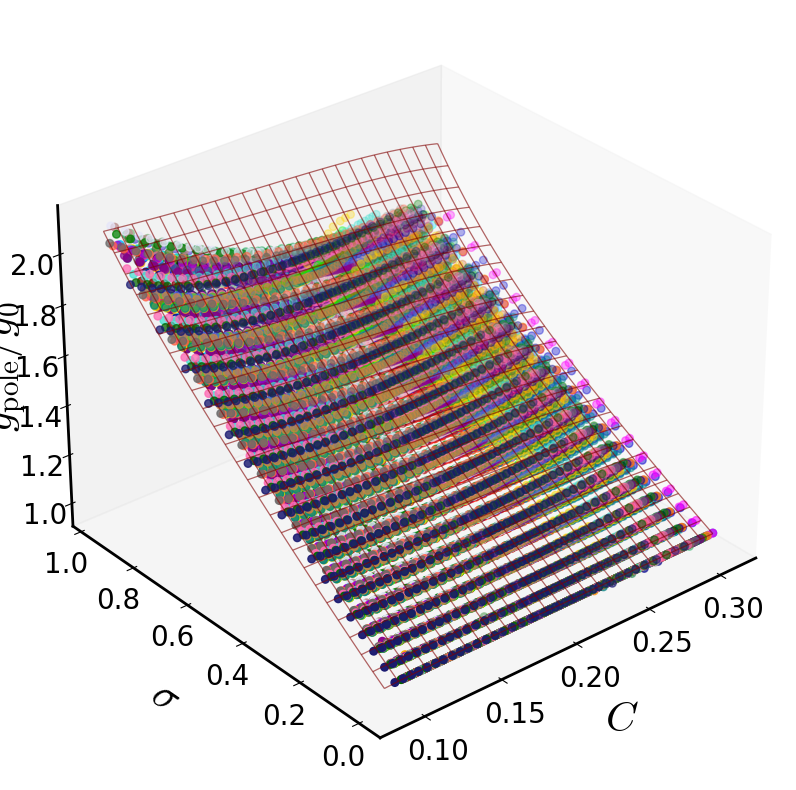

In [115]:
Surface_plot_funct_2(eos_data, x, y, z, xlabel=r'$C$',ylabel='$\sigma$',zlabel=r'$g_{\mathrm{pole}}/g_0$', 
                     view2=230, n_col=3, border_axes=8, X=x4,Y=y4,Z=Z4, l_w=0.9)

#### Universal relation for $g_{eq}$ (All NSs included)

In [116]:
def Regression_function_2(data_frame,x,y,w, z, pol_degree, x_power,y_power, w_power):
    # Data, targets
    train_data = data_frame[[x, y, w]].to_numpy()
    target = data_frame[z].to_numpy()
    
    #--------Polynomial features and defining the model---------------
    poly = PolynomialFeatures(degree=pol_degree) 
    model= LinearRegression(fit_intercept=True)
    #-----------Applying transformation to the data-------------------
    poly_train_data = poly.fit_transform(train_data)
    
    #-----------Trainig the regression model--------------------------
    model = model.fit(poly_train_data, target)
    
    #----------Scoring: R^2 index------------------------------------
    R_square_index = model.score(poly_train_data, target)
    
    #---------z=f(x,y) prediction with respect to the model----------
    z_trial = model.predict(poly_train_data)
    z_trial = pd.DataFrame(z_trial)
    
    #----------fitting optimizers (coefficients)---------------------
    intercept_coeff = model.intercept_
    model_coeff = model.coef_
    power_combinations = poly.powers_
    powers=pd.DataFrame(poly.powers_,columns=[x_power,y_power, w_power])
   
    return z_trial, R_square_index, intercept_coeff, model_coeff, power_combinations, powers


In [117]:
def Regression_function_3(data_frame,x,y,w,q, z, pol_degree, x_power,y_power, w_power, q_power):
    # Data, targets
    train_data = data_frame[[x, y, w, q]].to_numpy()
    target = data_frame[z].to_numpy()
    
    #--------Polynomial features and defining the model---------------
    poly = PolynomialFeatures(degree=pol_degree) 
    model= LinearRegression(fit_intercept=True)
    #-----------Applying transformation to the data-------------------
    poly_train_data = poly.fit_transform(train_data)
    
    #-----------Trainig the regression model--------------------------
    model = model.fit(poly_train_data, target)
    
    #----------Scoring: R^2 index------------------------------------
    R_square_index = model.score(poly_train_data, target)
    
    #---------z=f(x,y) prediction with respect to the model----------
    z_trial = model.predict(poly_train_data)
    z_trial = pd.DataFrame(z_trial)
    
    #----------fitting optimizers (coefficients)---------------------
    intercept_coeff = model.intercept_
    model_coeff = model.coef_
    power_combinations = poly.powers_
    powers=pd.DataFrame(poly.powers_,columns=[x_power,y_power, w_power, q_power])
   
    return z_trial, R_square_index, intercept_coeff, model_coeff, power_combinations, powers

In [118]:
x = 'C'; y = 'sigma'; w = 'eccentricity' ;z = 'g_eq_scaled' ; z_model = 'g_eq_scaled_model';

#### Cross-Validation

In [119]:
#cv_results = c_val_performace_results_for_k_2(df,x=x,y=y,w=w,z=z)
#cv_results
#optim_pol_degree = int(cv_results[cv_results['d(%)'] == cv_results['d(%)'].min()]['k'].iloc[0])

In [120]:
cv_results_g_eq = pd.read_csv('LOOCV_results/g_eq_LOOCV_results')
cv_results_g_eq

MAE  Max_Error           MSE       d(%)   MAPE(%)  Explained_Variance  \
0  0.012457   0.090990  2.345235e-04  60.239597  2.356113                 1.0   
1  0.003238   0.028102  1.992911e-05  40.535751  0.643018                 1.0   
2  0.000760   0.012911  1.232216e-06   4.337101  0.169832                 1.0   
3  0.000646   0.012945  1.010815e-06   3.838275  0.147062                 1.0   
4  0.000597   0.013014  9.265978e-07   3.448856  0.137110                 1.0   
5  0.000582   0.013116  9.029801e-07   2.856619  0.134236                 1.0   
6  0.000573   0.013054  8.834424e-07   2.769864  0.131815                 1.0   
7  0.000560   0.013089  8.552114e-07   2.777353  0.129038                 1.0   

     k  
0  1.0  
1  2.0  
2  3.0  
3  4.0  
4  5.0  
5  6.0  
6  7.0  
7  8.0

In [121]:
#optim_pol_degree = int(cv_results[cv_results['d(%)'] == cv_results['d(%)'].min()]['k'].iloc[0])
optim_pol_degree = 3

#### Linear regression on training data

In [122]:
df[z_model], R_2_index, E_00, E_nm, pow_comb_5, powers_5 = Regression_function_2(df,x = x,y = y,w = w ,z = z, pol_degree=optim_pol_degree,
                                              x_power = x,y_power=y,w_power=w)

In [123]:
R_2_index

0.9999763625907374

#### $R^2$ index

In [124]:
R_2_index

0.9999763625907374

#### Relative error on training data

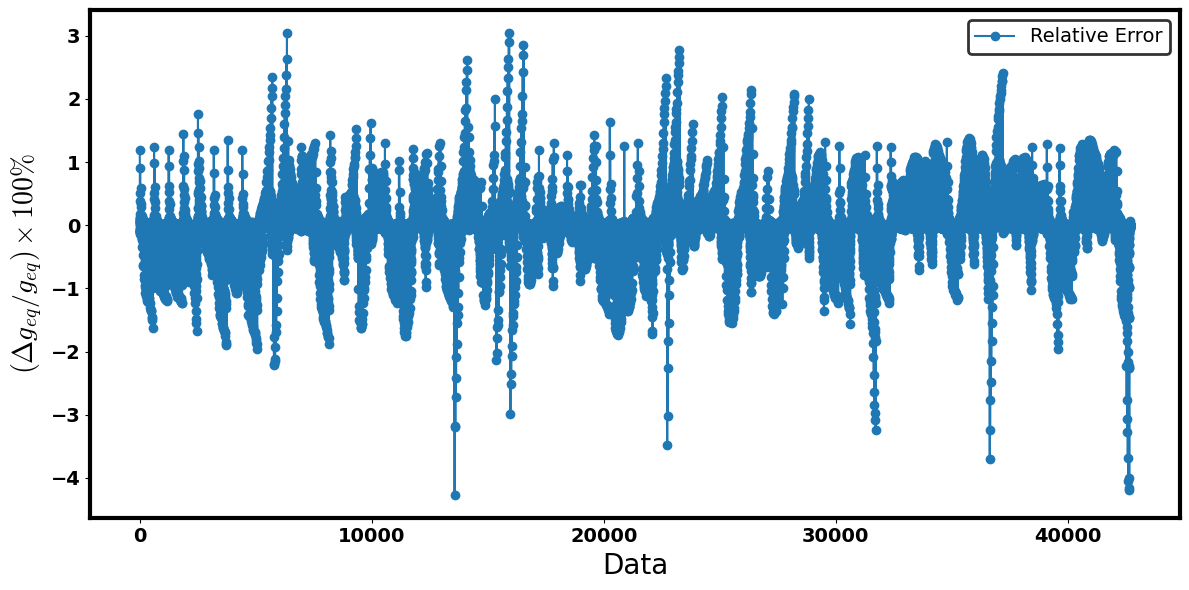

<Axes: xlabel='Data', ylabel='$(\\Delta g_{eq} /g_{eq})\\times 100\\%$'>

In [125]:
relative_training_error_plot(df, z ,z_model, xlabel='Data', 
                             ylabel=r'$(\Delta g_{eq} /g_{eq})\times 100\%$') 


In [126]:
training_error_funct(df, z , z_model)

train_Max_Error  d_max_training(%)  MAPE_taining(%)
0         0.012899           4.264131         0.169714

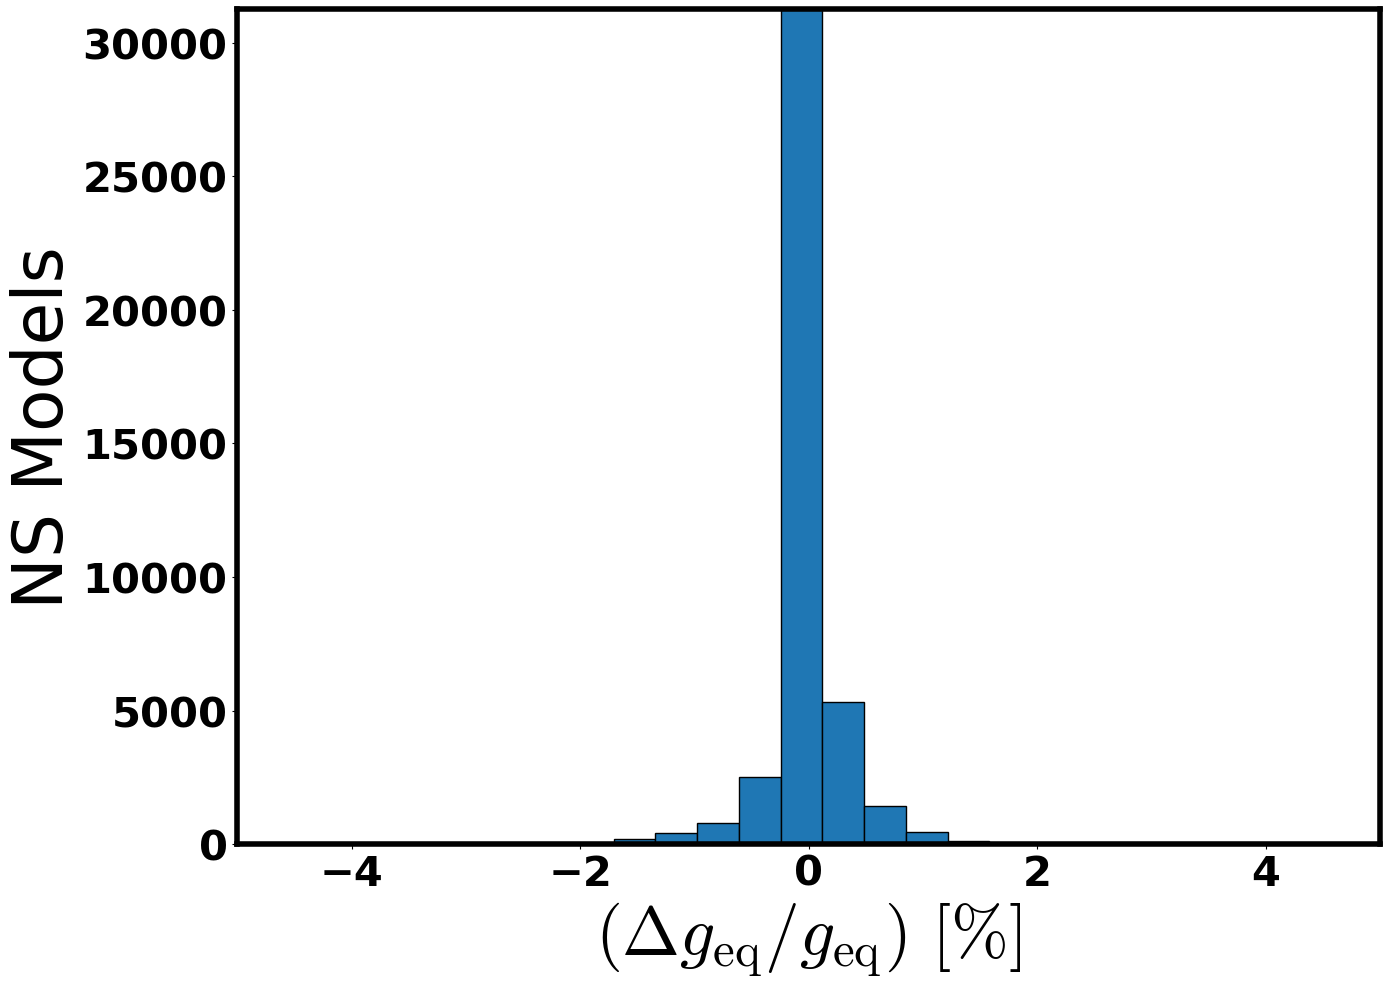

In [127]:
training_relative_error_hist(df, z , z_model, 
                             r'$(\Delta g_{\mathrm{eq}} /g_{\mathrm{eq}}) \  [\%]$', r'NS Models',n_bins=20,
                             x1_lim=-5, x2_lim=5)

### Model's coefficients

In [128]:
# model's intercept
E_00;
# model's other coefficients
E_nm;
# a_nm stored to data frame
coef=pd.DataFrame(E_nm,columns=["coef"])

In [129]:
E_nm

array([ 0.        ,  0.06866332, -1.69175782, -0.02976716, -0.28467956,
        2.33122575,  0.14131776,  0.53280091, -0.75836694,  0.83218179,
        0.33807042,  1.20592156,  0.12888786, -4.03577574,  2.63090429,
       -2.03273805, -0.22100945,  0.36927603,  0.23073066,  0.28904095])

In [130]:
def g_eq_funct(C,sigma,e):
    results=0
    for i in range(0,len(powers_5)):
        results+=(coef["coef"][i]*C**(powers_5["C"][i])*sigma**(powers_5["sigma"][i])*e**(powers_5["eccentricity"][i]))
      
    return E_00 + results 

g_eq_funct(C_s,sigma_s, e_s)

0.338070419688191*\mathcal{C}**3 + 1.20592155663032*\mathcal{C}**2*\sigma + 0.128887857187797*\mathcal{C}**2*e - 0.284679560623361*\mathcal{C}**2 - 4.0357757427521*\mathcal{C}*\sigma**2 + 2.63090429234693*\mathcal{C}*\sigma*e + 2.33122575049243*\mathcal{C}*\sigma - 2.03273805025505*\mathcal{C}*e**2 + 0.141317760072622*\mathcal{C}*e + 0.0686633222621077*\mathcal{C} - 0.221009453432658*\sigma**3 + 0.369276028155004*\sigma**2*e + 0.532800911941009*\sigma**2 + 0.23073065963261*\sigma*e**2 - 0.758366940518667*\sigma*e - 1.69175782343621*\sigma + 0.289040948522035*e**3 + 0.832181789667688*e**2 - 0.0297671570402134*e + 0.995124108230518

In [131]:
x5 = mesh_grid_funct_2(100,df,x_name = 'C', y_name = 'sigma', w_name = 'eccentricity')[0]
y5 = mesh_grid_funct_2(100,df, x_name = 'C', y_name = 'sigma', w_name = 'eccentricity')[1]
w5 = mesh_grid_funct_2(100,df, x_name = 'C', y_name = 'sigma', w_name = 'eccentricity')[2]

Z5 = g_eq_funct(x5,y5,w5)

In [142]:
def Surface_plot_funct_3(eos_data, x,y,w, z, xlabel,ylabel,wlabel,zlabel, view2, n_col,
                         border_axes, X,Y,W, Z, l_w):
    
    fig = plt.figure(figsize=(12 ,8)) 
    labels_text_size = 35
    ax = fig.add_subplot(111, projection='3d')

    dot_size = 40
    font_size = 22
    label_pad = 32
    label_size = 22

    
    #######################################################################################################
   
    for i in range(0, len(eos_data)):
        scatter = ax.scatter(eos_data[i][x].to_numpy(),eos_data[i][y].to_numpy(),eos_data[i][z].to_numpy(),
                   c = eos_data[i][w].to_numpy(), s = dot_size, cmap='viridis', marker='o')    
    
    
    # Add colorbar
    cbar = plt.colorbar(scatter,  shrink=0.5)
    cbar.set_label(wlabel, fontsize=font_size,rotation=0)
    cbar.ax.tick_params(labelsize=15)
    
    #######################################################################################################
    
    
    
    ax.view_init(30, view2)   
    ax.set_xlabel(xlabel, fontsize=font_size,labelpad=label_pad) 
    ax.set_ylabel(ylabel, fontsize=font_size,labelpad=label_pad) 
    
    ax.zaxis.set_rotate_label(False) 
    ax.set_zlabel(zlabel, fontsize=font_size,labelpad=label_pad,rotation = 90)

    #ax.yaxis._axinfo['label']['space_factor'] = 3.0   
    ax.zaxis._axinfo['label']['space_factor'] = -30.0
    
    ax.zaxis.labelpad = 5#0.4 
    
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.zaxis.set_tick_params(labelsize=label_size)
    
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.line.set_linewidth(2)
    
    ax.grid(False)

    
    plt.tight_layout()
    #plt.savefig('test_2.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.5)
    
    plt.show()
   

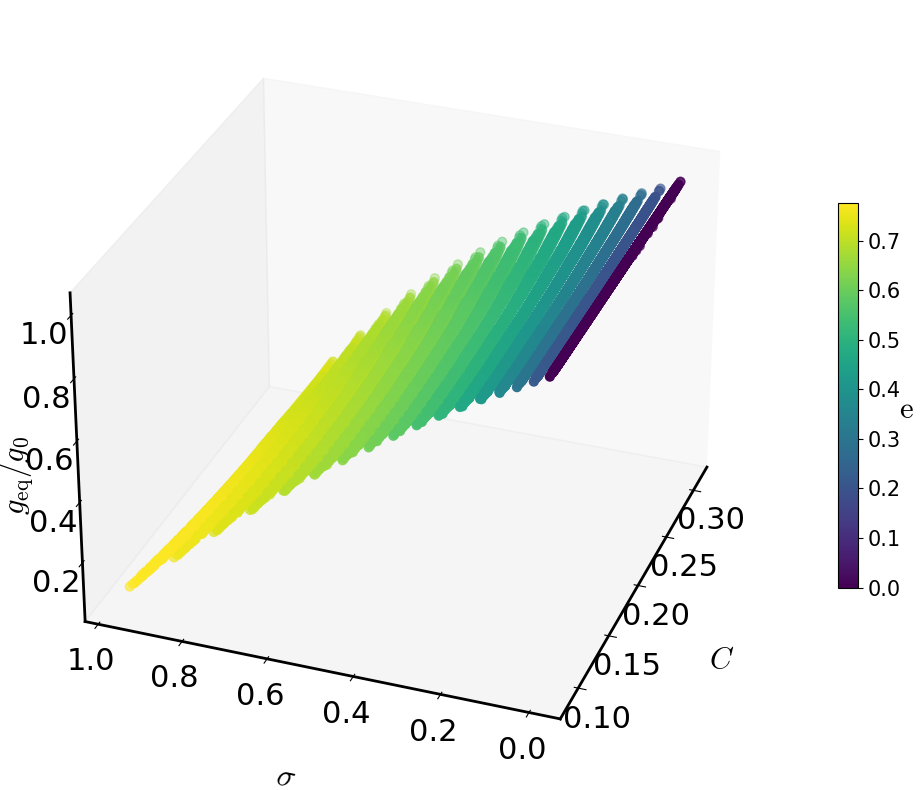

In [143]:
Surface_plot_funct_3(eos_data, x,y,w,z, xlabel=r'$C$',ylabel='$\sigma$',
                     wlabel = r'$\mathrm{e}$',zlabel=r'$g_{\mathrm{eq}}/g_0$', 
                     view2=200, n_col=3, border_axes=8, X=x5,Y=y5,W = w5,Z=Z5, l_w=1.5)

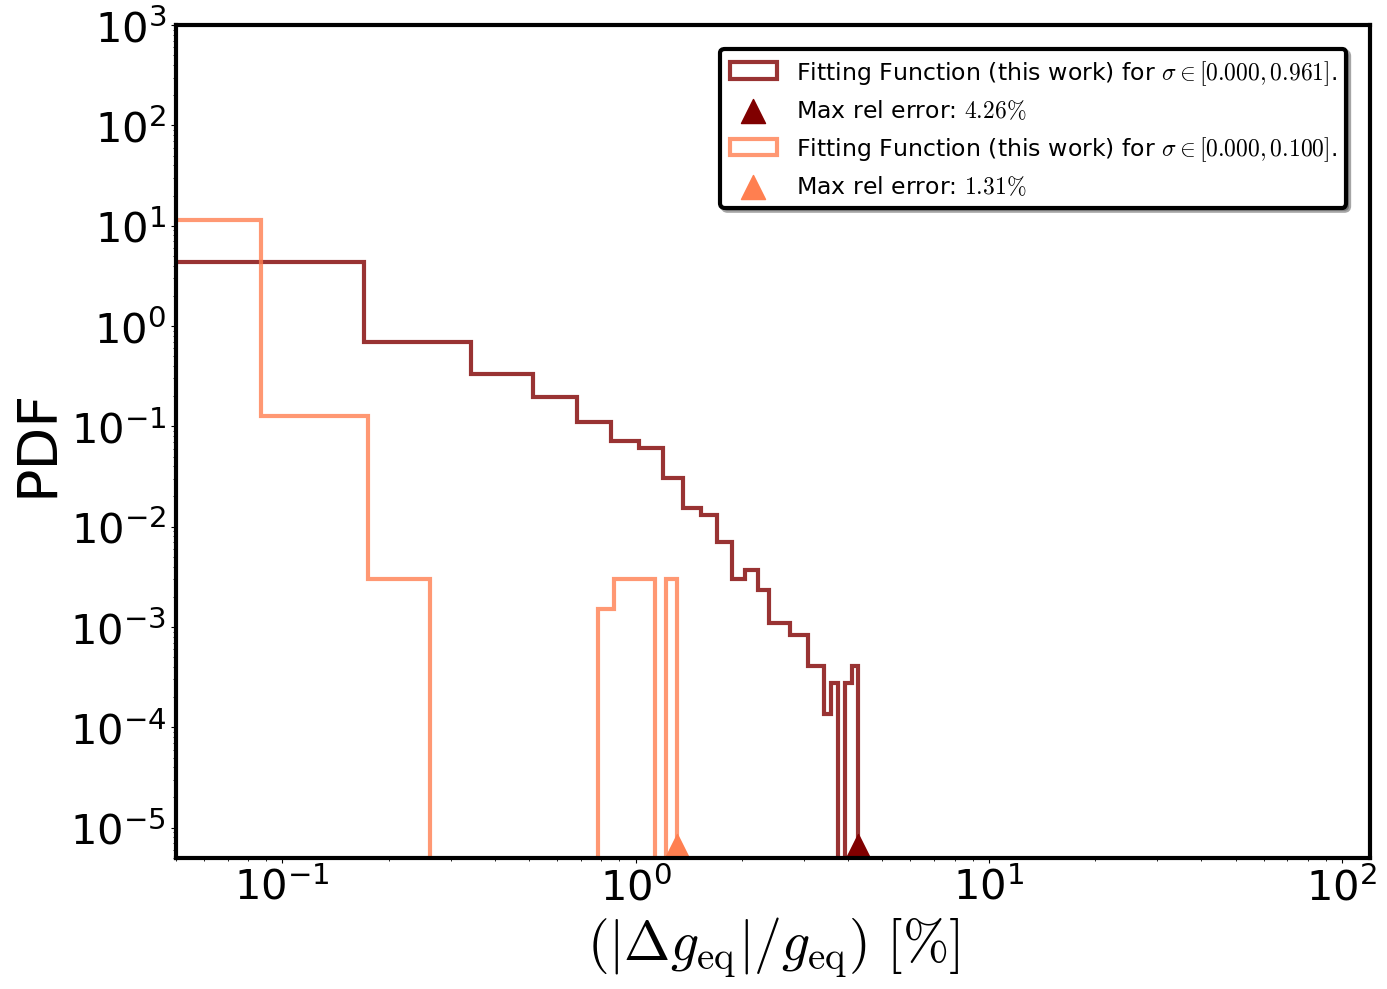

In [145]:
fig,ax = plt.subplots(figsize=(14, 10),)
labels_text_size = 40
plt.xticks(fontsize=30) #fontweight="bold"
plt.yticks(fontsize=30)

xlabel = r'$(|\Delta g_{\mathrm{eq}}| /g_{\mathrm{eq}}) \ [\%]$'
#ylabel = 'NSs PDF'
ylabel = 'PDF'



plt.xlabel(xlabel,size=labels_text_size)
plt.ylabel(ylabel,size=labels_text_size)

bins = 45
alpha = 0.8


y_reg_grav_model = abs(100*(-df[z]+df[z_model])/df[z]).hist(
    density = True,
    bins=bins-20,
    lw = 3,
    edgecolor ='maroon', 
    histtype='step',
    zorder = 1, 
    alpha = alpha,
    label = f"Fitting Function (this work) for $\sigma \in [0.000, {np.round(df2['sigma'].max(), 3)}]$.", color = 'maroon').autoscale(enable = True, axis = 'both', tight = True)


vertical_lines = [4.264130569493755, None]  # Adjust these values based on your requirements
plt.scatter(vertical_lines[0], 0.65e-5, color='maroon', marker='^', s=300, zorder=2, label=r'Max rel error: $4.26\%$')  




y_reg_grav_model = abs(100*(-df[df['sigma']<=0.1][z]+df[df['sigma']<=0.1][z_model])/df[df['sigma']<=0.1][z]).hist(
    density = True,
    bins=bins-30,
    lw = 3,
    edgecolor ='coral', 
    histtype='step',
    zorder = 1, 
    alpha = alpha,
    label = f"Fitting Function (this work) for $\sigma \in [0.000, 0.100]$.", 
   color = 'coral').autoscale(enable = True, axis = 'both', tight = True)


vertical_lines = [1.307, None]  # Adjust these values based on your requirements
plt.scatter(vertical_lines[0], 0.65e-5, color='coral', marker='^', s=300, zorder=2, label=r'Max rel error: $1.31\%$')  

plt.yscale('log')
plt.xscale('log')


plt.ylim(0.5e-5,1000)
plt.xlim(0.5e-1,120)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3.0)

plt.grid(False)
leg = plt.legend(loc="upper right",ncol=1, borderaxespad=1, prop={'size': 17}, shadow=True, fontsize="large")    #,bbox_to_anchor=(1,1)
leg.get_frame().set_linewidth(3.0)
leg.get_frame().set_edgecolor('black')
    
plt.tight_layout()
#plt.savefig('g_e_c_sigma_e_hist.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.2)
plt.show()

In [147]:
abs(100*(-df[z]+df[z_model])/df[z]).max()

4.264130569493755

In [538]:
abs(100*(-df[df['sigma']<=0.1][z]+df[df['sigma']<=0.1][z_model])/df[df['sigma']<=0.1][z]).max()

1.3072154897475385

#### EoS insensitive relation for $(d\log R/d \theta) max$ (Static NSs excluded)

In [148]:
x = 'C'; y = 'sigma'; w = 'Rpol/Req' ;z = 'dR_dtheta_max' ; z_model = 'dR_dtheta_max_model';

#### Cross Validation

In [149]:
#cv_results = c_val_performace_results_for_k_2(df2,x=x,y=y,w=w,z=z)
#cv_results
#optim_pol_degree = int(cv_results[cv_results['d(%)'] == cv_results['d(%)'].min()]['k'].iloc[0])


In [150]:
cv_results_dLogR = pd.read_csv('LOOCV_results/dLogR_dtheta_LOOCV_results.txt')
cv_results_dLogR

MAE  Max_Error           MSE       d(%)   MAPE(%)  Explained_Variance  \
0  0.003774   0.026318  2.375680e-05  79.081525  4.046781                 1.0   
1  0.000669   0.021541  1.258866e-06   5.234422  0.395973                 1.0   
2  0.000497   0.007817  7.828603e-07   3.227351  0.231198                 1.0   
3  0.000438   0.007156  6.900567e-07   5.798164  0.182552                 1.0   
4  0.000416   0.006877  6.532774e-07   2.612371  0.169510                 1.0   
5  0.000403   0.006840  6.320654e-07   3.912433  0.159825                 1.0   
6  0.000395   0.006831  6.143983e-07   2.627716  0.157560                 1.0   
7  0.000382   0.006846  5.988247e-07   3.535615  0.144146                 1.0   

     k  
0  1.0  
1  2.0  
2  3.0  
3  4.0  
4  5.0  
5  6.0  
6  7.0  
7  8.0

In [151]:
optim_pol_degree = 3

#### Linear regression on training data

In [152]:
df2[z_model], R_2_index, F_00, F_nm, pow_comb_6, powers_6 = Regression_function_2(df2,x = x,y= y, w = w ,z = z, 
                           pol_degree=optim_pol_degree, x_power = x,y_power=y, w_power = w)

### $R^2$ index

In [153]:
R_2_index

0.9999491798375334

#### Relative error on training data

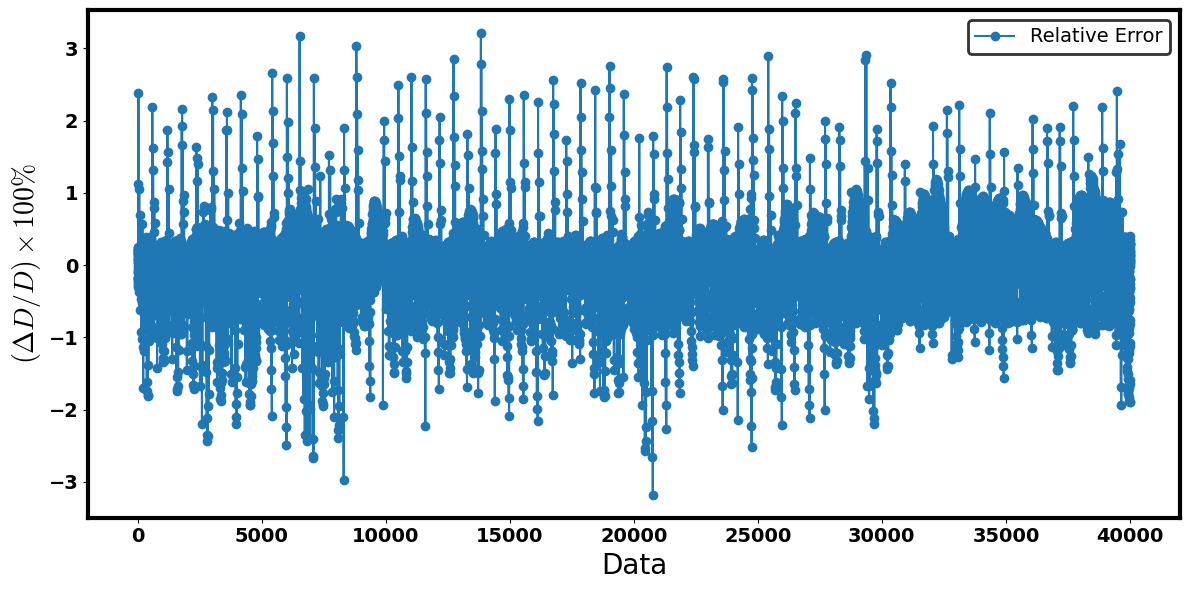

<Axes: xlabel='Data', ylabel='$(\\Delta D /D)\\times 100\\%$'>

In [154]:
relative_training_error_plot(df2, z ,z_model, xlabel='Data', 
                             ylabel=r'$(\Delta D /D)\times 100\%$') 

In [155]:
training_error_funct(df2, z , z_model)

train_Max_Error  d_max_training(%)  MAPE_taining(%)
0         0.007789           3.212846         0.231035

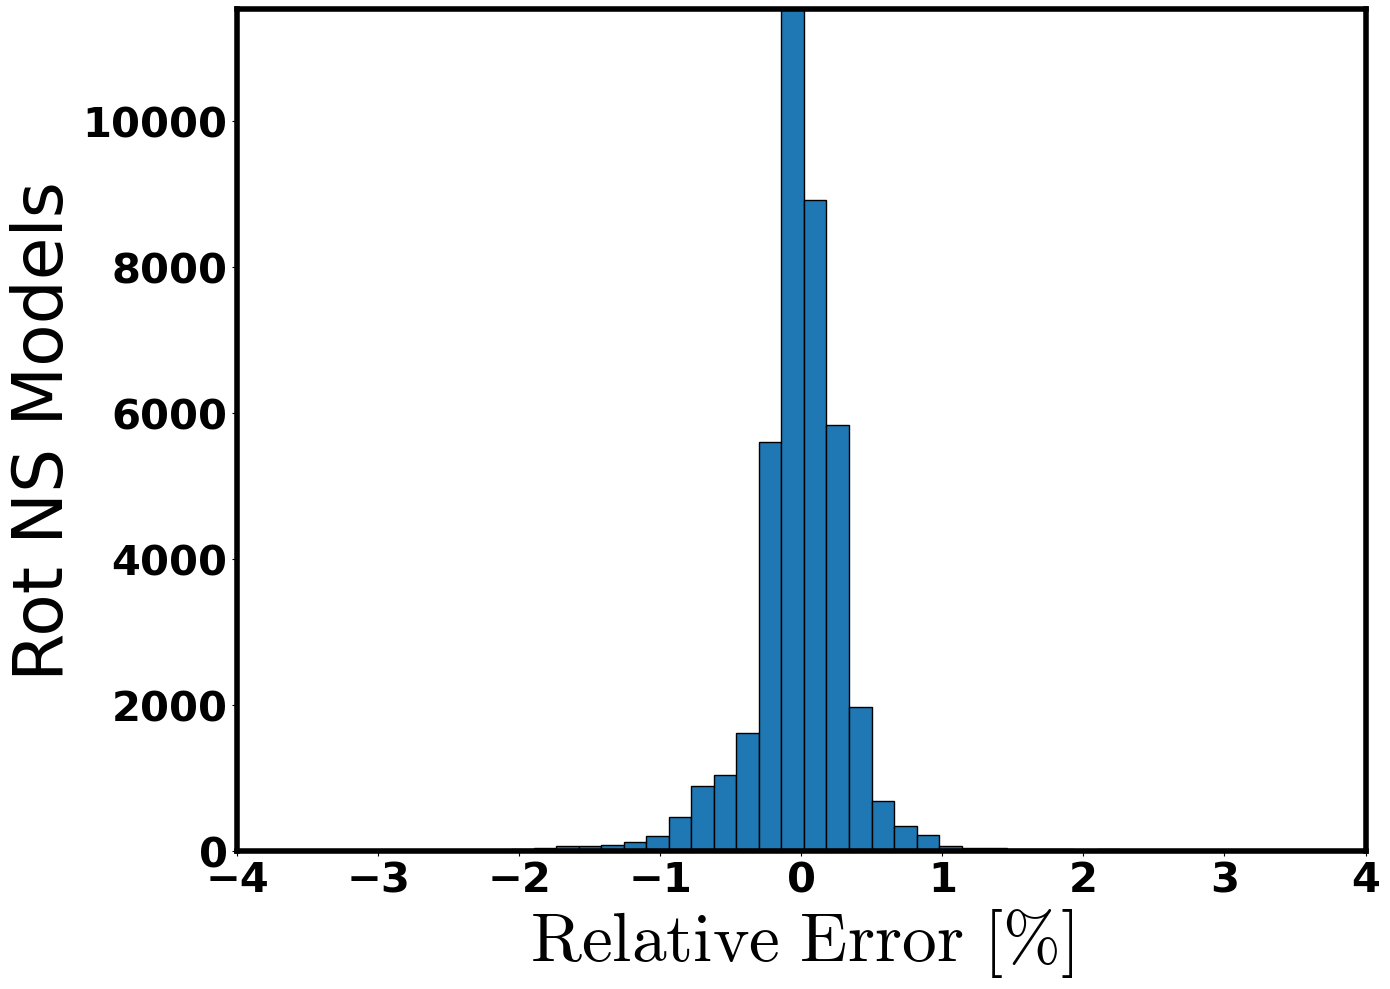

In [156]:
training_relative_error_hist(df2, z , z_model, 
                             r'$\mathrm{Relative \ Error} \ [\%]$', r'Rot NS Models',n_bins=40,
                             x1_lim=-4, x2_lim=4)

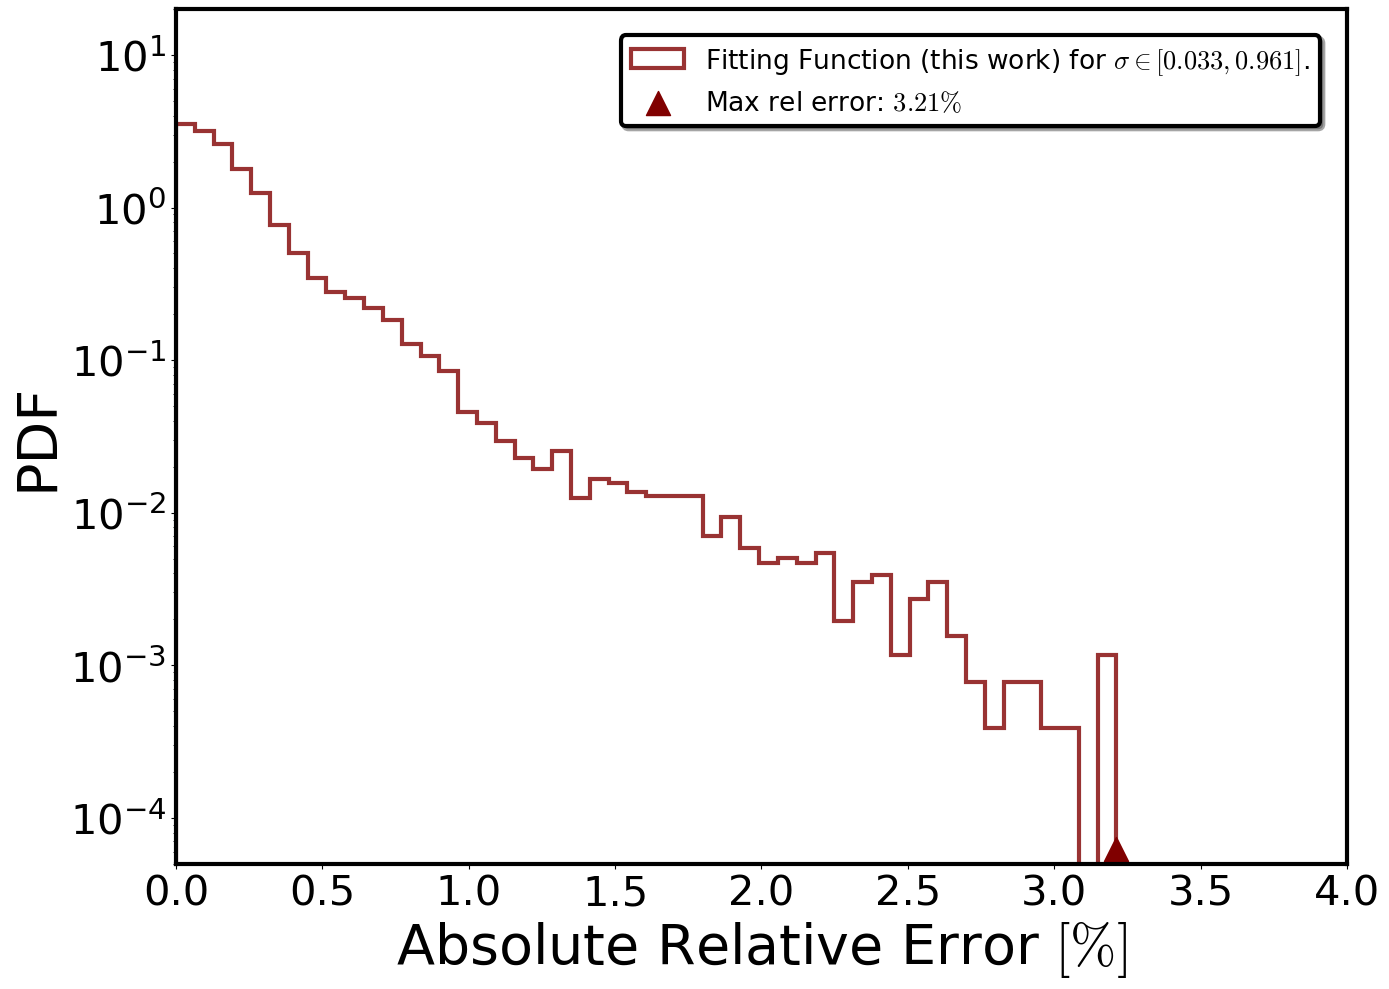

In [157]:
fig,ax = plt.subplots(figsize=(14, 10),)
labels_text_size = 40
plt.xticks(fontsize=30) #fontweight="bold"
plt.yticks(fontsize=30)


xlabel = r'Absolute Relative Error$\ [\%]$'
#ylabel = r'Rotating NSs PDF'

ylabel = r'PDF'


plt.xlabel(xlabel,size=labels_text_size)
plt.ylabel(ylabel,size=labels_text_size)

bins = 50
alpha = 0.8

log_reg_model = abs(100*(-df2[z]+df2[z_model])/df2[z]).hist(
    density = True,
    lw = 3,
    bins=bins,
    edgecolor ='maroon',
    histtype='step',
    zorder = 1,
    alpha = alpha, 
    label = f"Fitting Function (this work) for $ \sigma \in[{np.round(df2['sigma'].min(), 3)}, {np.round(df2['sigma'].max(), 3)}]$.",
    color = 'maroon').autoscale(enable = True, axis = 'both', tight = True)

vertical_lines = [3.2128461268526847]  # Adjust these values based on your requirements
plt.scatter(vertical_lines[0], 0.625e-4, color='maroon',  marker='^', s=300, zorder=2, label=r'Max rel error: $ 3.21 \%$')  



plt.yscale('log')

#plt.xlim(1e-2,10)


plt.ylim(0.5e-4,20)

plt.xlim(0,4)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3.0)

plt.grid(False)
leg = plt.legend(loc="upper right",ncol=1, borderaxespad=1, prop={'size': 19}, shadow=True, fontsize="large")    #,bbox_to_anchor=(1,1)
leg.get_frame().set_linewidth(3.0)
leg.get_frame().set_edgecolor('black')
    
plt.tight_layout()
#plt.savefig('log_der_hist.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.2)
plt.show()

### Model's coefficients

In [158]:
# model's intercept
F_00;
# model's other coefficients
F_nm; 
# F_nm stored to data frame
coef=pd.DataFrame(F_nm,columns=["coef"])

In [159]:
def dLogR_dtheta_max_funct(C,sigma,r_s):
    results=0
    for i in range(0,len(powers_6)):
        results+=(coef["coef"][i]*C**(powers_6[x][i])*sigma**(powers_6[y][i])*r_s**(powers_6[w][i]))
      
    return F_00 + results 

dLogR_dtheta_max_funct(C_s,sigma_s, r_s)

-0.403276601294769*\mathcal{C}**3 + 0.66151909779781*\mathcal{C}**2*\sigma + 2.57434191156734*\mathcal{C}**2*r_{\star} - 2.23108454812405*\mathcal{C}**2 - 8.6762573974298*\mathcal{C}*\sigma**2 - 39.6796750694061*\mathcal{C}*\sigma*r_{\star} + 38.4663786236091*\mathcal{C}*\sigma - 45.0567823427942*\mathcal{C}*r_{\star}**2 + 87.0956609309219*\mathcal{C}*r_{\star} - 42.1349805655765*\mathcal{C} + 4.07991541887699*\sigma**3 + 30.4880078789053*\sigma**2*r_{\star} - 27.2418077134931*\sigma**2 + 72.1353182129612*\sigma*r_{\star}**2 - 130.455828718701*\sigma*r_{\star} + 58.559061635722*\sigma + 53.9663039266245*r_{\star}**3 - 146.85852284865*r_{\star}**2 + 131.341936932986*r_{\star} - 38.441438473346

In [160]:
x6 = mesh_grid_funct_2(100,df2,x_name = x, y_name = y, w_name = w)[0]
y6 = mesh_grid_funct_2(100,df2, x_name = x, y_name = y, w_name = w)[1]
w6 = mesh_grid_funct_2(100,df2, x_name = x, y_name = y, w_name = w)[2]

Z6 = dLogR_dtheta_max_funct(x6,y6,w6)

In [161]:
def Surface_plot_funct_3(eos_data, x,y,w, z, xlabel,ylabel,wlabel,zlabel, view2, n_col,
                         border_axes, X,Y,W, Z, l_w):
    
    fig = plt.figure(figsize=(12 ,8)) 
    labels_text_size = 27
    ax = fig.add_subplot(111, projection='3d')

    dot_size = 40
    font_size = 22
    label_pad = 22
    label_size = 22

    
    #######################################################################################################
   
    for i in range(0, len(eos_data)):
        scatter = ax.scatter(eos_data[i][x].to_numpy(),eos_data[i][y].to_numpy(),eos_data[i][z].to_numpy(),
                   c = eos_data[i][w].to_numpy(), s = dot_size, cmap='viridis', marker='o')    
    
    
    # Add colorbar
    cbar = plt.colorbar(scatter,  shrink=0.5)
    cbar.set_label(wlabel, fontsize=font_size, rotation=0)
    cbar.ax.tick_params(labelsize=15)
    #ax.plot_wireframe(X, Y, Z, rstride=40, cstride=40,edgecolor='blue' ,color = 'black',
    #                  alpha=6.6, lw = l_w, antialiased=True)
    
    #######################################################################################################
    
    
    
    ax.view_init(30, view2)   
    ax.set_xlabel(xlabel, fontsize=font_size,labelpad=label_pad) 
    ax.set_ylabel(ylabel, fontsize=font_size,labelpad=label_pad) 
    
    ax.zaxis.set_rotate_label(False) 
    ax.set_zlabel(zlabel, fontsize=font_size,labelpad=label_pad,rotation = 90) 
    ax.yaxis._axinfo['label']['space_factor'] = 3.0   

    ax.zaxis.labelpad = 10
    
    ax.xaxis.set_tick_params(labelsize=label_size)
    ax.yaxis.set_tick_params(labelsize=label_size)
    ax.zaxis.set_tick_params(labelsize=label_size)
    
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.line.set_linewidth(2)
    
    ax.grid(False)


    #leg = plt.legend(loc="best",ncol=n_col, borderaxespad=border_axes, prop={'size': 10}, shadow=True, fontsize="large",bbox_to_anchor=(1,1))    #,bbox_to_anchor=(1,1)
    #leg.get_frame().set_linewidth(4.0)
    #leg.get_frame().set_edgecolor('black')
    
    plt.tight_layout()
    #plt.savefig('test.png',dpi=100,facecolor="w",bbox_inches='tight',transparent=True, pad_inches=0.5)
    
    plt.show()
   

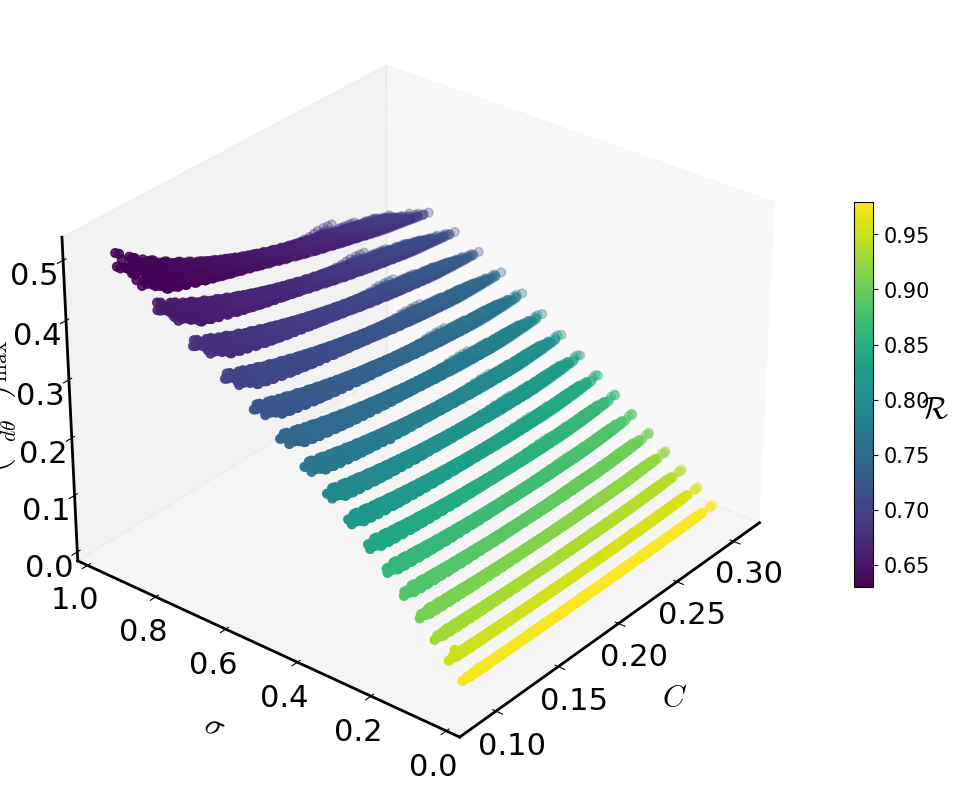

In [162]:
Surface_plot_funct_3(eos_data2, x,y,w,z, xlabel=r'$C$',ylabel='$\sigma$',
                     wlabel = r'$\mathcal{R}$',zlabel=r'$\left(\frac{d\log R}{d\theta}\right)_{\mathrm{max}}$', 
                     view2=219, n_col=3, border_axes=8, X=x6,Y=y6,W = w6,Z=Z6, l_w=1.5)